# Projet TAL - RI
_Charlotte Kruzic & Zoé Marquis_
# Étape 1

In [5]:
!pip install pandas unidecode lime

Defaulting to user installation because normal site-packages is not writeable


In [6]:

# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')

import string
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn import model_selection
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
import seaborn as sns
sns.set_theme(style="darkgrid")

set_config(display='diagram')

nltk.download('stopwords')
nltk.download('punkt')

2024-05-03 14:31:43.346698: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 14:31:43.566034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 14:31:44.169448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/zoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zoe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Charger les données & exploration

In [7]:
df_train = pd.read_csv("train.tsv", sep='\t')

In [8]:
df_train.head()

,category,headline,text,url
0,sports,"L'Ouganda à l'assaut des ""fimbu"" de la RDC","L'Ouganda, placé 79e au classement FIFA le 4 a...",https://www.bbc.com/afrique/sports-48730747
1,business,Stopper la détérioration de l’environnement po...,La responsable de la biodiversité des Nations ...,https://www.bbc.com/afrique/articles/cevdz4xrp42o
2,sports,Coupe d'Afrique des nations 2022 : le sélectio...,"Le sélectionneur de la Sierra Leone, John Keis...",https://www.bbc.com/afrique/region-59881445
3,business,Tissus africains : pourquoi les teintureries h...,"Depuis plus de six siècles, une vaste zone sit...",https://www.bbc.com/afrique/region-61202726
4,business,Les revenus pendant la pandémie des dix hommes...,"Pendant la pandémie de coronavirus, la richess...",https://www.bbc.com/afrique/monde-55812018


In [9]:
print(df_train.columns)

Index(['category', 'headline', 'text', 'url'], dtype='object')


### Nettoyer les données 

In [10]:
# identifier les valeurs manquantes
valeurs_manquantes = df_train.isnull().sum()
print(valeurs_manquantes) 
# pas de valeur manquante

category    0
headline    0
text        0
url         0
dtype: int64


In [11]:
# identifier les lignes dupliquées
dupliquees = df_train.duplicated()
print(dupliquees.sum())
# 1 ligne dupliquée

1


In [12]:
# supprimer les lignes dupliquées
df_train = df_train.drop_duplicates()
dupliquees = df_train.duplicated()
print(dupliquees.sum())

0


In [13]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1475 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1475 non-null   object
 1   headline  1475 non-null   object
 2   text      1475 non-null   object
 3   url       1475 non-null   object
dtypes: object(4)
memory usage: 57.6+ KB
None


Le jeu de données contient 1475 lignes.  
Toutes les colonnes contiennent du texte (donc il n'est pas nécessaire de traiter les données numériques).   
On s'intéresse seulement aux colonnes `headline` et `text`.

### Préparer les données pour l'apprentissage de la catégorie
à partir du titre et du texte uniquement

Séparation des données de la catégorie à prédire

In [14]:
X = df_train[['headline', 'text']]
y = df_train.category

In [15]:
X.head()

,headline,text
0,"L'Ouganda à l'assaut des ""fimbu"" de la RDC","L'Ouganda, placé 79e au classement FIFA le 4 a..."
1,Stopper la détérioration de l’environnement po...,La responsable de la biodiversité des Nations ...
2,Coupe d'Afrique des nations 2022 : le sélectio...,"Le sélectionneur de la Sierra Leone, John Keis..."
3,Tissus africains : pourquoi les teintureries h...,"Depuis plus de six siècles, une vaste zone sit..."
4,Les revenus pendant la pandémie des dix hommes...,"Pendant la pandémie de coronavirus, la richess..."


In [16]:
# afficher toutes les catégories
y.unique()

array(['sports', 'business', 'politics', 'health', 'technology'],
      dtype=object)

### Prétraitements des données

- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

In [17]:
# def split_into_tokens_nltk(desc) :
#     return word_tokenize(desc, language='french')
# 
# # Liste des mots vides de NLTK + signes de ponctuation
# nltk_stopwords = stopwords.words('french')+list(string.punctuation)
# # +['``'] : à essayer


# Liste des mots vides de NLTK + signes de ponctuation
nltk_stopwords = set(stopwords.words('french')) | set(string.punctuation) 

# Fonction de tokenisation personnalisée
def split_into_tokens_nltk(desc):
    tokens = word_tokenize(desc, language='french')
    tokens = [token.lower() for token in tokens if token.lower() not in nltk_stopwords]
    return tokens

On va essayer plusieurs prétraitements différents supplémentaires dont : 
- Lemmatisation
- Désuffixation
- N-grammes

In [18]:
stemmer = SnowballStemmer(language='french')

def stemming(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def stemming_transformer(X):
    return X.apply(stemming)

In [19]:
# def lemmatize_text(text):
#     # modèle français de Spacy
#     nlp = spacy.load("fr_core_news_sm")
#     lemmatized_text = ' '.join([token.lemma_ for token in nlp(text)])
#     return lemmatized_text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text, language='french')
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_text

def lemmatization_transformer(X):
    return X.apply(lemmatize_text)

On va essayer 3 types de traits : 
- TF-IDF (avec différentes fréquences)
- Sac de mots (avec différentes fréquences)
- Informations statistiques : longueur en nombre de caractères et nombre approximatif de phrases

In [20]:
def text_stats(descriptions):
    return [{"length": len(text), "num_sentences": text.count(".")}
            for text in descriptions]
    
text_stats_transformer = FunctionTransformer(text_stats)
text_stats_vectorizer = DictVectorizer(sparse=False)
min_max_scaler = MinMaxScaler()    

In [21]:
tfidf_001 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            min_df = 0.01)
bow_001 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          min_df=0.01)

## différents n grammes
tfidf_001_ngram2 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            min_df = 0.01,
                            ngram_range=(1, 2)
                            )
bow_001_ngram2 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          ngram_range=(1, 2),
                          min_df=0.01)

tfidf_001_ngram3 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            min_df = 0.01,
                            ngram_range=(1, 3)
                            )
bow_001_ngram3 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          ngram_range=(1, 3),
                          min_df=0.01)

tfidf_001_ngram4 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            min_df = 0.01,
                            ngram_range=(1, 4)
                            )
bow_001_ngram4 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          ngram_range=(1, 4),
                          min_df=0.01)

## différentes fréquences 
tfidf_010 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            min_df = 0.1,)
bow_010 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True,
                            min_df=0.1,)

tfidf_005 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            min_df = 0.05,)
bow_005 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True,
                            min_df=0.05,)

### Modèles

In [22]:
models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Mutinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier()),
    ('SVM', SVC(kernel='rbf')),
]

### Évaluation

Validation croisée à 5 plis

In [23]:
# X_train, X_val, y_train, y_val = 
# # train_test_split(X, y, test_size=0.2, random_state=3, shuffle=True)

In [24]:
stratkfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [25]:
def evaluate(modele, traits):
    model_pipeline = make_pipeline(traits, modele)
    y_pred = model_selection.cross_val_predict(model_pipeline, X, y,
                                               cv=stratkfold, n_jobs=-1)
    return y_pred

In [26]:
def run(chaines, modeles):
    classification_reports = {}

    for identifiant, colonne_transformateur in chaines:
        classification_reports[identifiant] = {}
        
        for name, model in models :
            y_pred = evaluate(model, traits=colonne_transformateur)
            
            report = classification_report(y, y_pred, output_dict=True)
            
            classification_reports[identifiant][name] = {
                "accuracy" : report["accuracy"],
                "f1-score" : report["macro avg"]["f1-score"],
                "precision" : report["macro avg"]["precision"],
                "recall" : report["macro avg"]["recall"],
            }
        
    return classification_reports

### Visualiser pour comparer

In [27]:
def afficher_chaines(reports):
    for chaine_num, chaine_data in reports.items():
        fig, axs = plt.subplots(2, 2, figsize=(8, 6))
        fig.suptitle(chaine_num) 

        metrics = ['accuracy', 'f1-score', 'precision', 'recall']

        for ax, metric in zip(axs.flatten(), metrics):
            model_names = list(chaine_data.keys())
            metric_values = [model_data[metric] for model_data in chaine_data.values()]
            
            
            mean_metric = np.mean(metric_values)
            max_metric = np.max(metric_values)
            
            ax.axvline(mean_metric, color='r', linestyle='--', label=f'Mean ({mean_metric:.2f})')
            ax.axvline(max_metric, color='g', linestyle='--', label=f'Max ({max_metric:.2f})')
            

            ax.barh(model_names, metric_values, color='b')
            ax.set_title(metric.upper()) 
            ax.set_xlabel(metric.capitalize())  
            ax.set_ylabel('Modèles')  
            ax.invert_yaxis()  
            ax.set_xlim(0, 1)
            
            ax.legend()
            
        plt.tight_layout()
        plt.show()

In [28]:
def comparer_chaines(reports):
    metrics = ['accuracy', 'f1-score', 'precision', 'recall']
    metric_values = {metric: [] for metric in metrics}

    for chaine_num, chaine_data in reports.items():
        longueur = len(chaine_data.keys())
        for model, values in chaine_data.items():
            for metric in metrics:
                metric_values[metric].append((chaine_num, model, values[metric]))
                

    for metric in metrics:
        fig, axs = plt.subplots(2, 2, figsize=(8, 6))
        fig.suptitle(f'Comparaison de la métrique {metric.capitalize()} par modèle')  # Titre de la figure

        for i, ax in enumerate(axs.flat):
            values = metric_values[metric][i*longueur:(i+1)*longueur]

            chaine_names = [value[0] for value in values]
            model_names = [value[1] for value in values]
            metric_scores = [value[2] for value in values]
            
            mean_metric_score = np.mean(metric_scores)
            max_metric_score = np.max(metric_scores)
            
            ax.axvline(mean_metric_score, color='r', linestyle='--', label=f'Moyenne ({mean_metric_score:.2f})')
            ax.axvline(max_metric_score, color='g', linestyle='--', label=f'Maximum ({max_metric_score:.2f})')

            ax.barh(model_names, metric_scores, color='b')
            ax.set_title(chaine_names[0])  
            ax.set_xlabel(chaine_names[0]) 
            ax.set_ylabel('Chaines')  
            ax.invert_yaxis() 
            ax.set_xlim(0, 1)
            ax.legend()
            
        plt.tight_layout()

    plt.show()


### Premières chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

Et on utilise les traits suivants :

| n° | headline | text |
| --- | --- | --- |
| 1 | tf-idf (fréquence = 0.01) | tf-idf (fréquence = 0.01) | 
| 2 | sac de mots (fréquence = 0.01) | sac de mots (fréquence = 0.01) | 
| 3 | tf-idf (fréquence = 0.01) |  sac de mots (fréquence = 0.01) | 
| 4 | sac de mots (fréquence = 0.01) |  tf-idf (fréquence = 0.01) | 

In [25]:
chaines = [
    ('chain1', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_tfidf_001', tfidf_001, 'text'),
        ]
    )),
    
    ('chain2', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
        ]
    )),
    
    ('chain3', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
        ]
    )),
    
    ('chain4', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_tfidf_001', tfidf_001, 'text'),
        ]
    )),
]


In [26]:
# 1ère chaine
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

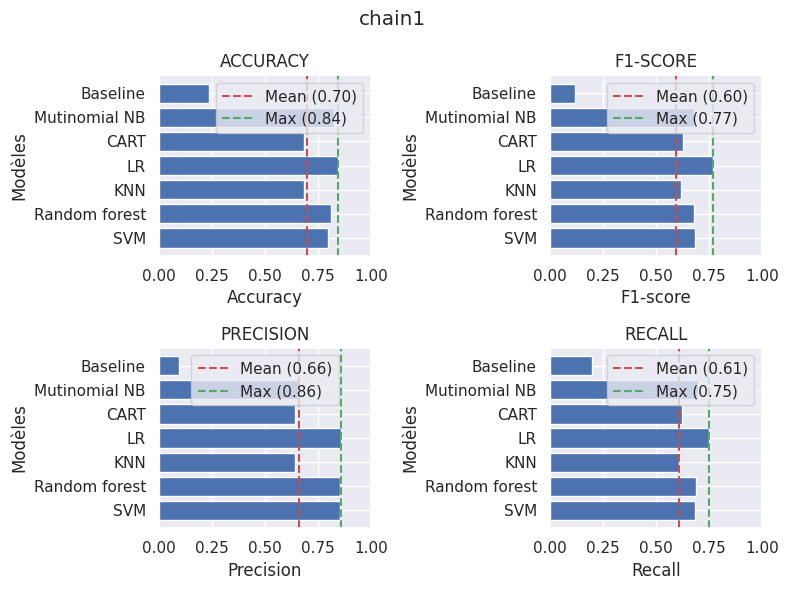

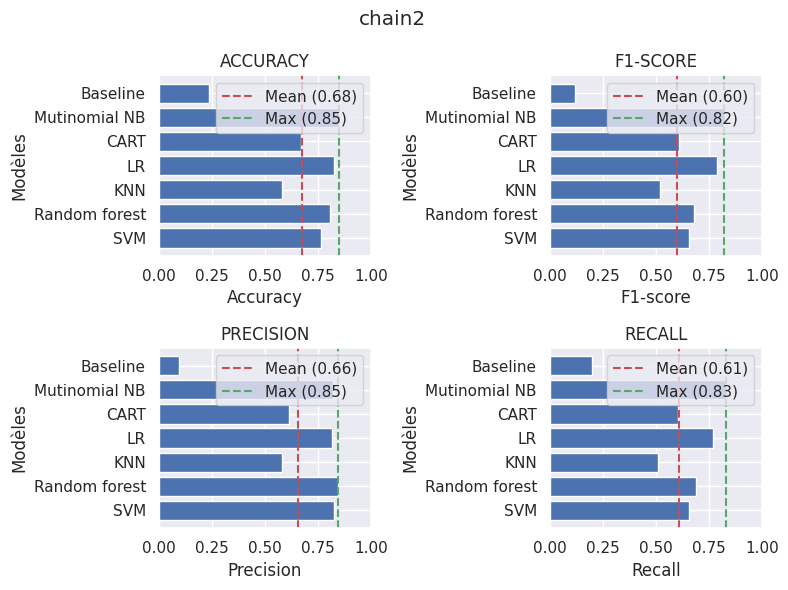

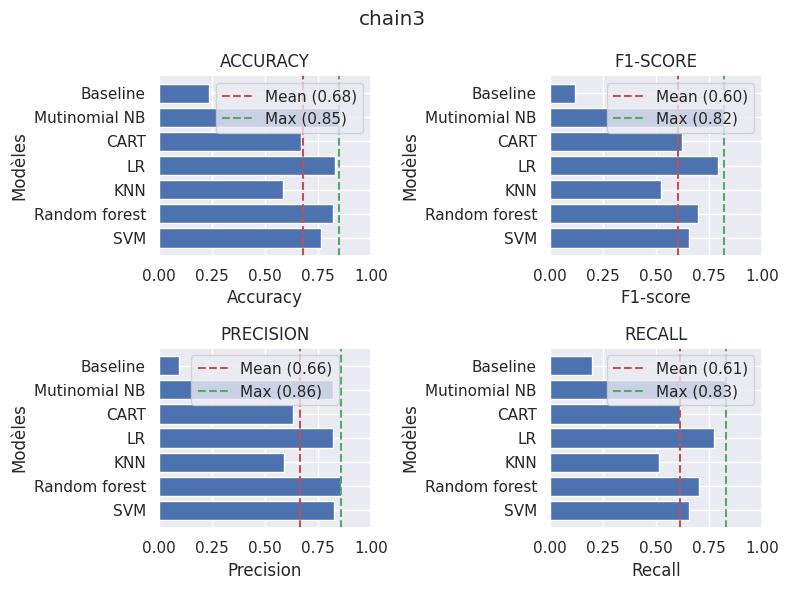

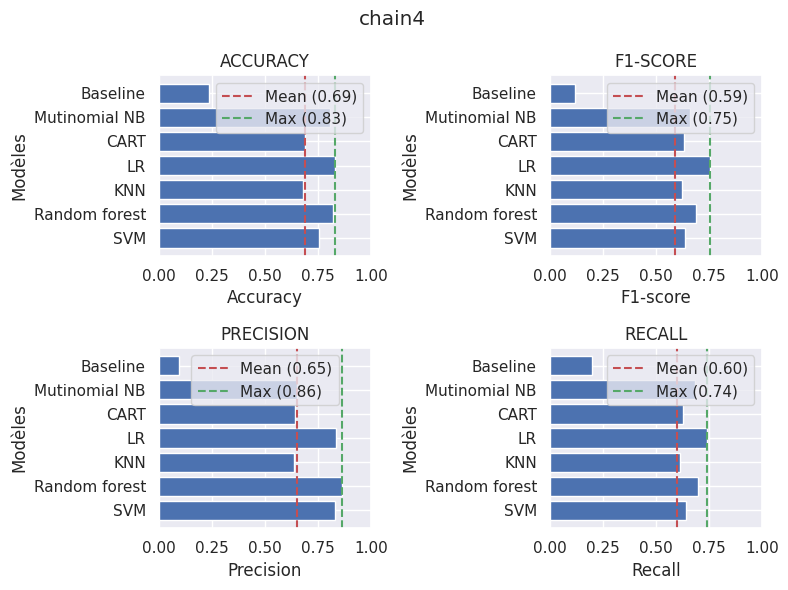

In [27]:
# 1ère chaine
afficher_chaines(classification_reports)

On s'aperçoit tout de suite que les 4 meilleurs modèles sont (presque) à chaque fois 
- Multinomial NB
- LR (Régression Logistique)
- Random forest
- SVM

Nous redéfinissons donc la liste des modèles que nous utiliserons : 

In [28]:
models = [
    ('Mutinomial NB', MultinomialNB()),
    ('LR', LogisticRegression()),
    ('Random forest', RandomForestClassifier()),
    ('SVM', SVC(kernel='rbf')),
]

In [29]:
# 1ère chaine
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

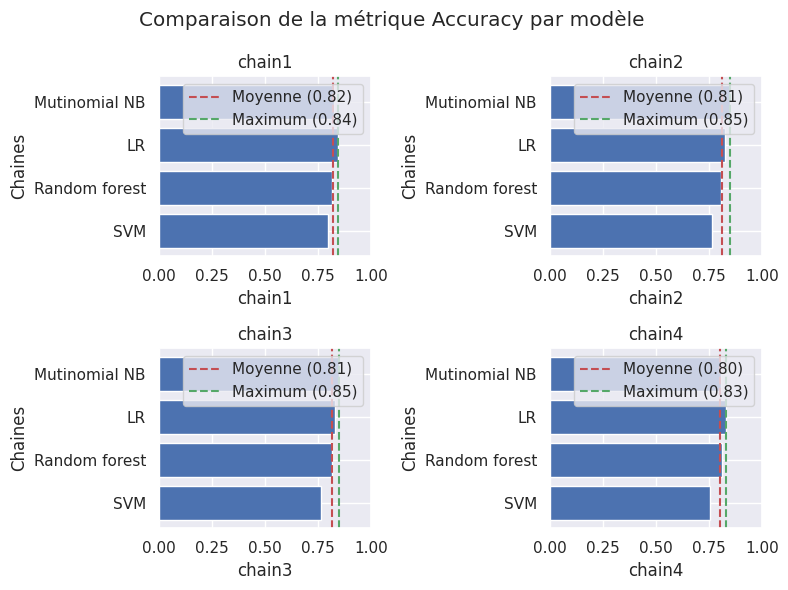

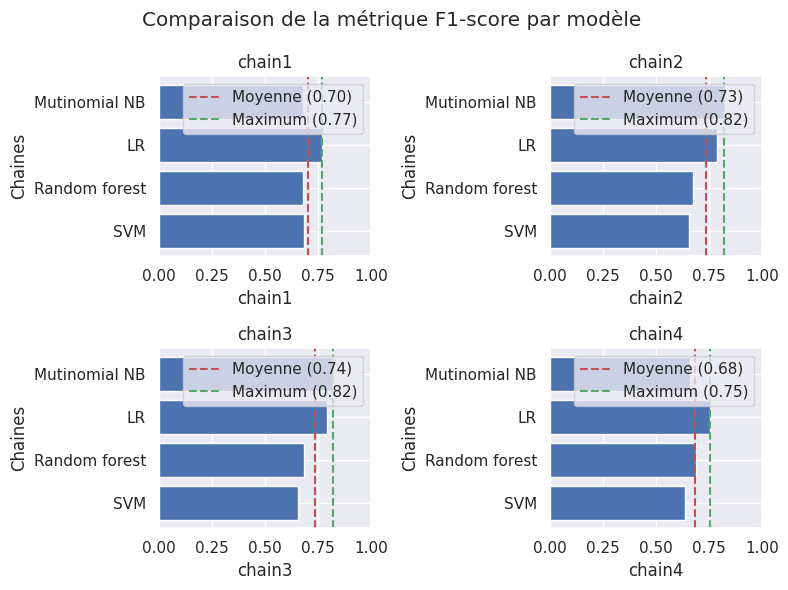

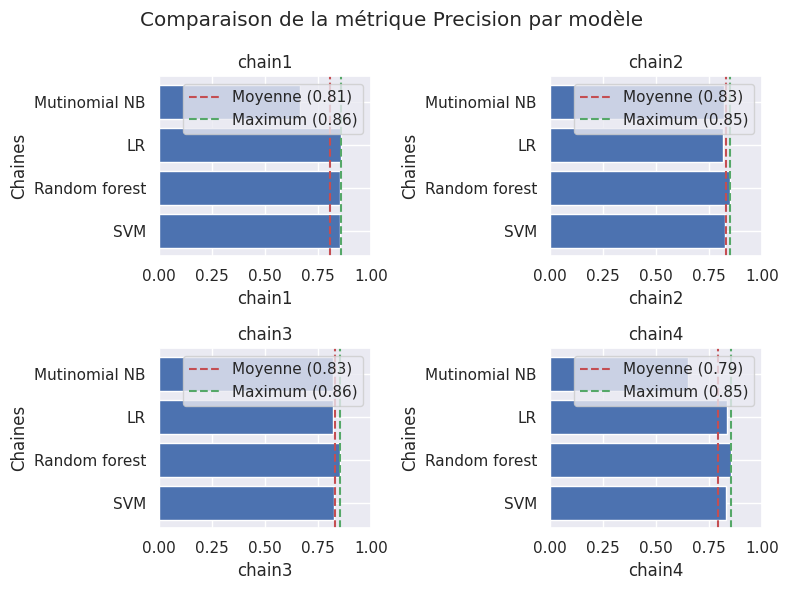

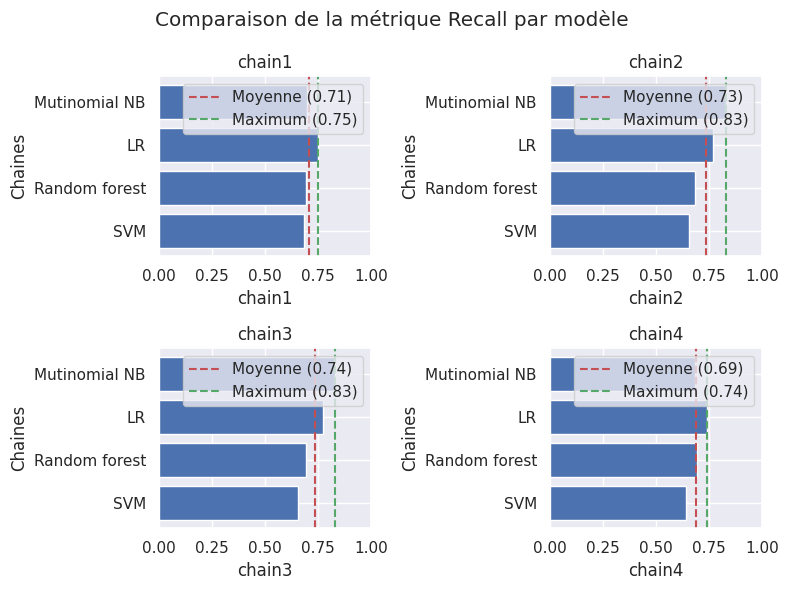

In [30]:
# 1ère chaine
comparer_chaines(classification_reports)

On élimine les chaines 1 et 4 car elles ont un F1-score moins bons.  
On garde la chaine 3 qui a une meilleure précision.

Essayons maintenant d'ajouter les traits d'informations statistiques.

### Deuxièmes chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

Et on utilise les traits suivants :

| n° | headline | text |
| --- | --- | --- |
| 3 | tf-idf (fréquence = 0.01) |  sac de mots (fréquence = 0.01) | 
| 5 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 6 | tf-idf (fréquence = 0.01) + informations statistiques |  sac de mots (fréquence = 0.01) | 
| 7 | tf-idf (fréquence = 0.01) + informations statistiques |  sac de mots (fréquence = 0.01) + informations statistiques | 

In [31]:
chaines = [
    
    ('chain3', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
        ]
    )),
    
    ('chain5', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'headline_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'headline'
         )
        ]
    )),
    
    ('chain7', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'headline_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'headline'
         ), (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
]


In [32]:
# 2ème chaine
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

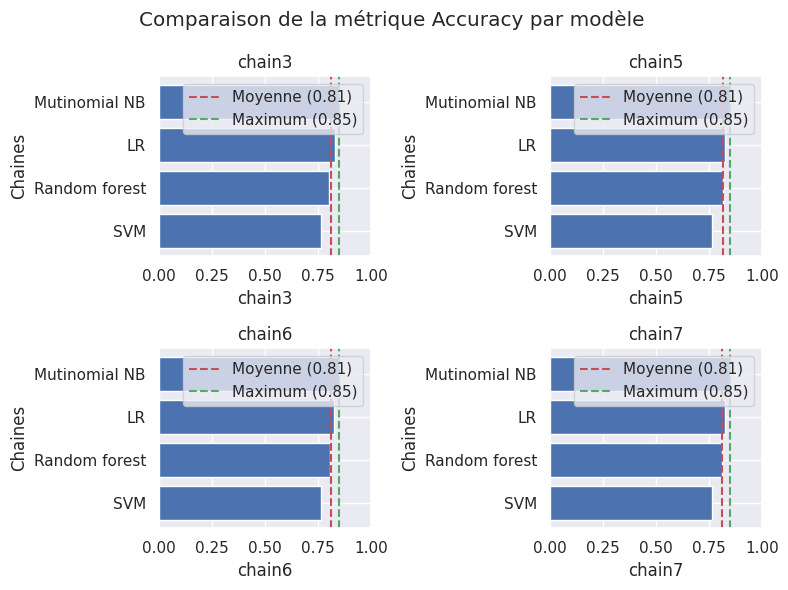

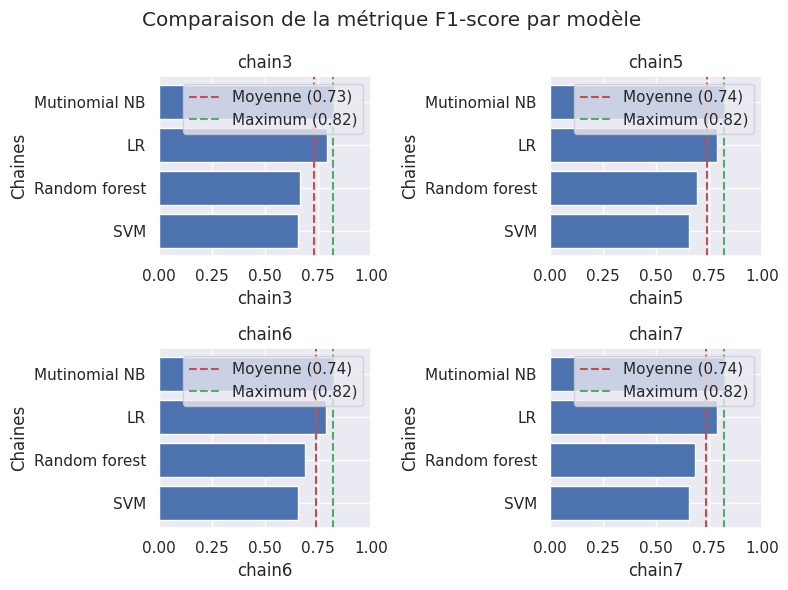

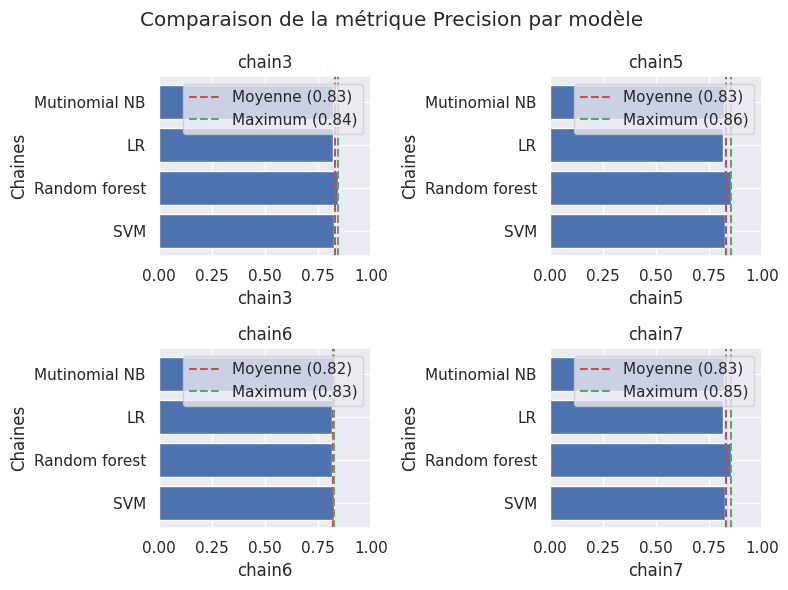

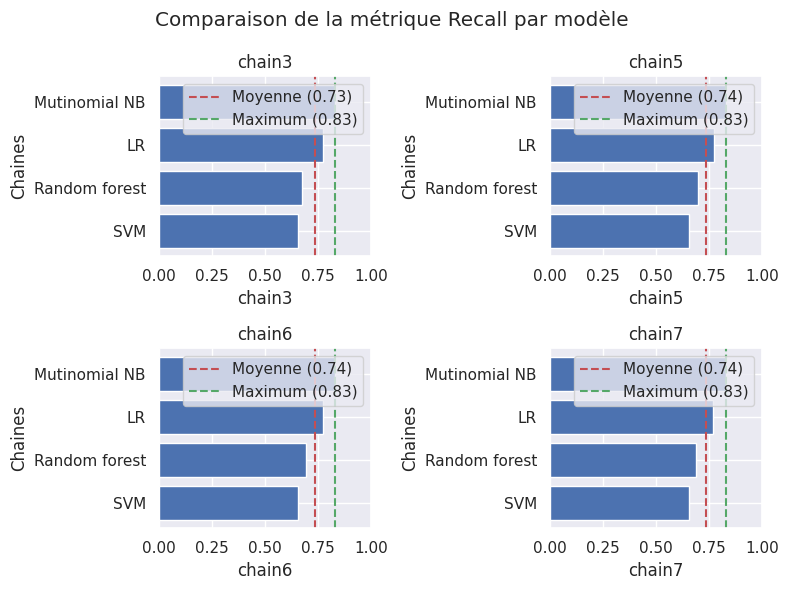

In [33]:
# 2ème chaine
comparer_chaines(classification_reports)

Les mesures sont peu impactées par ce changement de traits.  
On garde la chaine 5, légèrement meilleur en terme de précision.   
On supprime aussi le modèle SVM qui n'est jamais le plus performant.

In [34]:
models = [
    ('Mutinomial NB', MultinomialNB()),
    ('LR', LogisticRegression()),
    ('Random forest', RandomForestClassifier()),
]

### Troisièmes chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **N-grammes**

Et on utilise les traits suivants :

| n° | headline | text | n-gramme |
| --- | --- | --- | --- |
| 5 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 1 |
| 8 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 2 |
| 9 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 3 |
| 10 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 4 |

In [35]:
chaines = [
    ('chain5', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain8', ColumnTransformer(
        [
            ('headline_tfidf_001_2G', tfidf_001_ngram2, 'headline'),
            ('text_bow_001_2G', bow_001_ngram2, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain9', ColumnTransformer(
        [
            ('headline_tfidf_001_3G', tfidf_001_ngram3, 'headline'),
            ('text_bow_001_3G', bow_001_ngram3, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain10', ColumnTransformer(
        [
            ('headline_tfidf_001_4G', tfidf_001_ngram4, 'headline'),
            ('text_bow_001_4G', bow_001_ngram4, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [36]:
# 3ème chaine
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

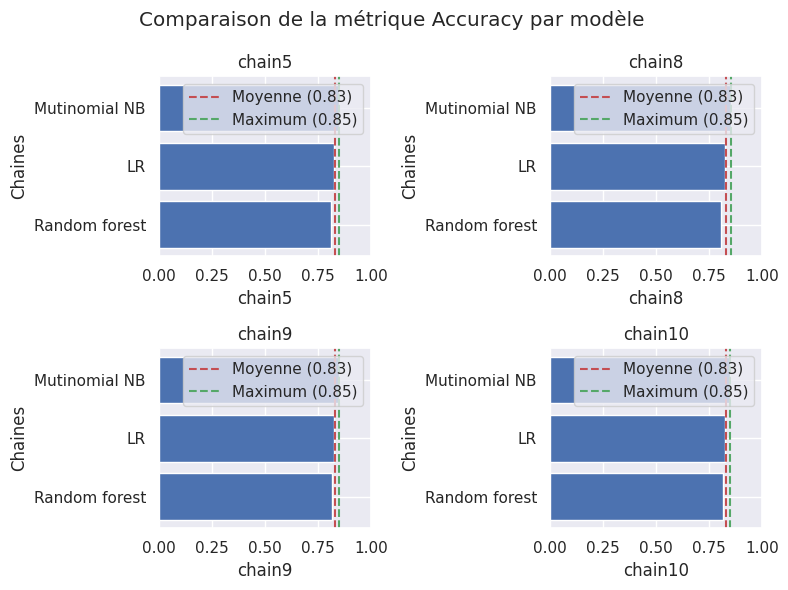

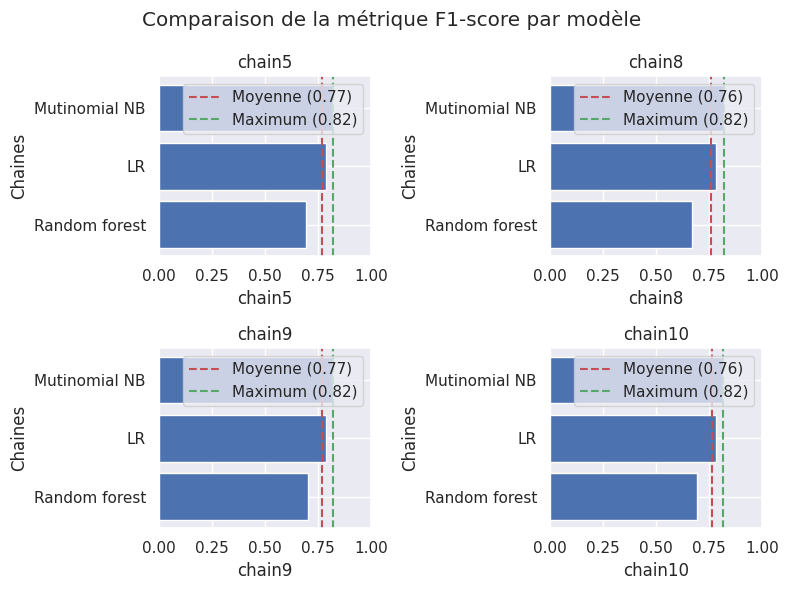

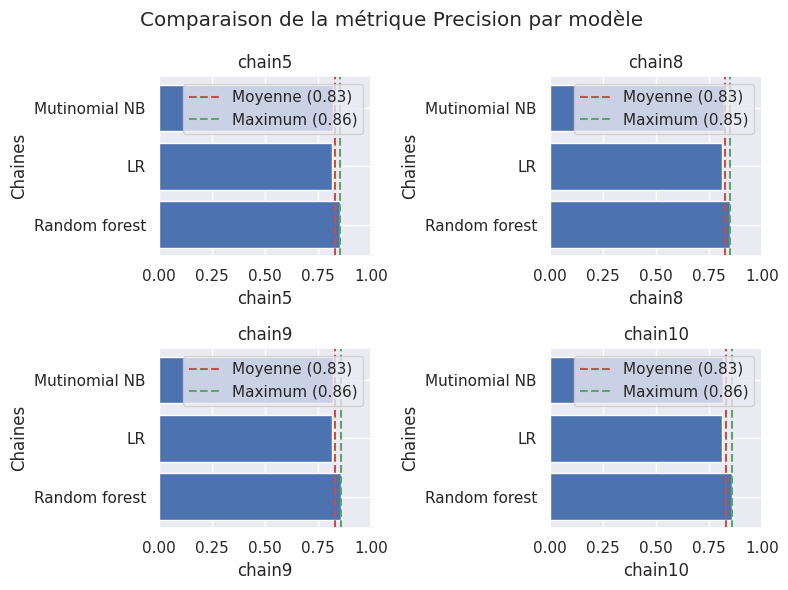

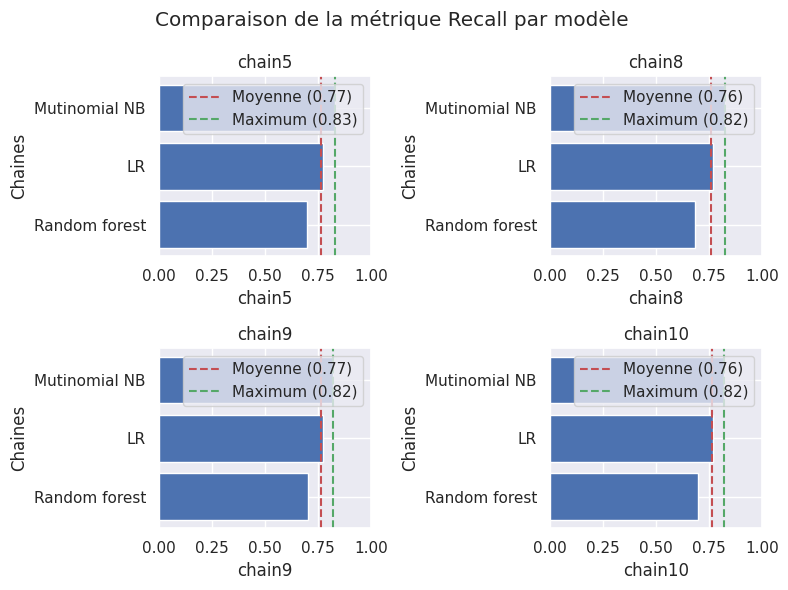

In [37]:
# 3ème chaine
comparer_chaines(classification_reports)

On garde la chaine 5 qui a les mêmes mesures que les autres chaines pour l'exactitude et le F1 score, mais est légèrement meilleure pour le rappel.  
Les n-grammes n'apportent rien

##### On essaye les n-grammes lorsq'uon utilise TF-IDF pour le texte.

In [38]:
chaines = [
    ('chain5', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain8TFIDF', ColumnTransformer(
        [
            ('headline_tfidf_001_2G', tfidf_001_ngram2, 'headline'),
            ('text_tfidf_001_2G', tfidf_001_ngram2, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain9TFIDF', ColumnTransformer(
        [
            ('headline_tfidf_001_3G', tfidf_001_ngram3, 'headline'),
            ('text_tfidf_001_3G', tfidf_001_ngram3, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain10TFIDF', ColumnTransformer(
        [
            ('headline_tfidf_001_4G', tfidf_001_ngram4, 'headline'),
            ('text_tfidf_001_4G', tfidf_001_ngram4, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [39]:
# 3ème chaine bis
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

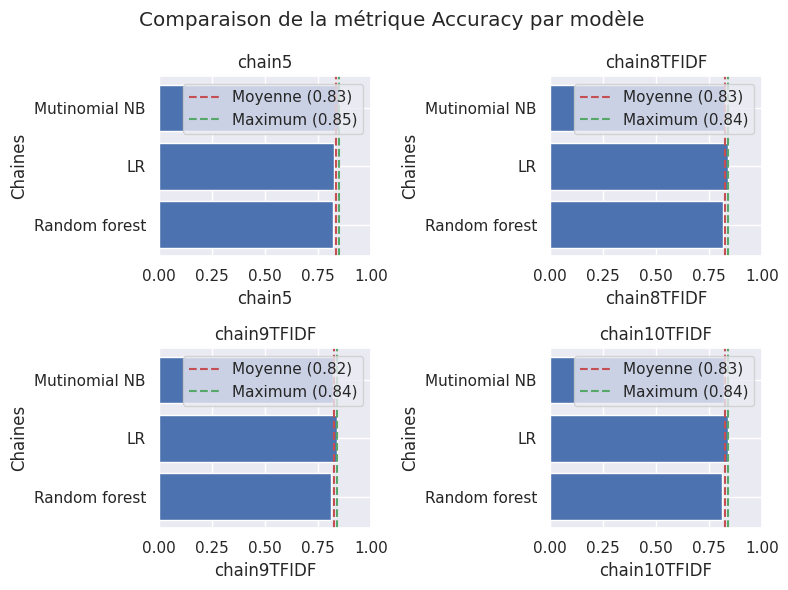

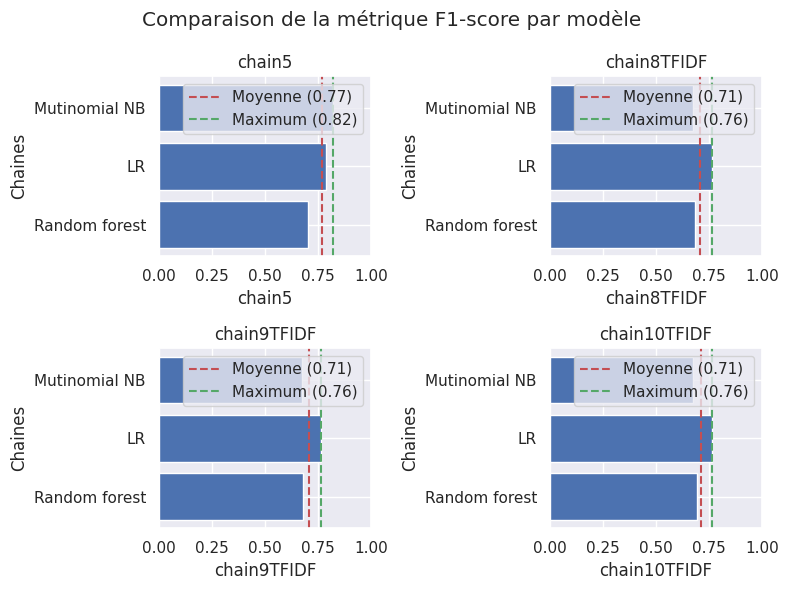

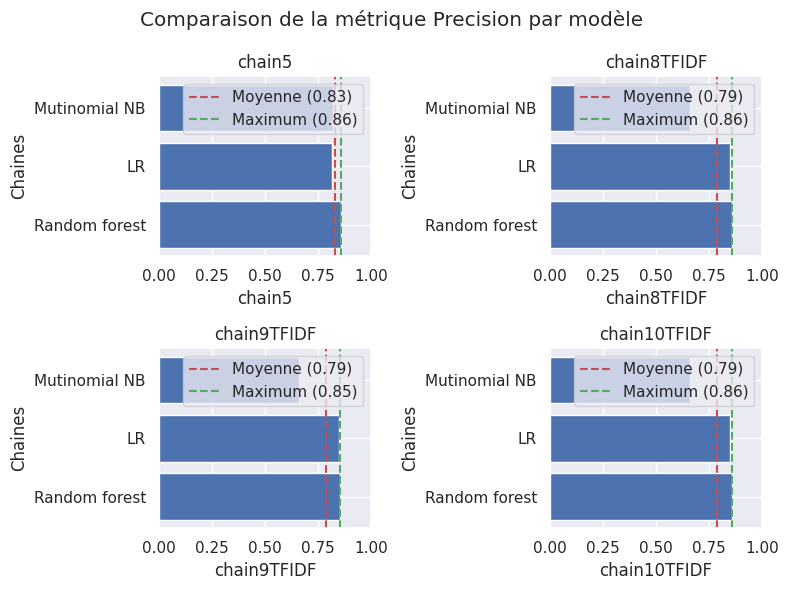

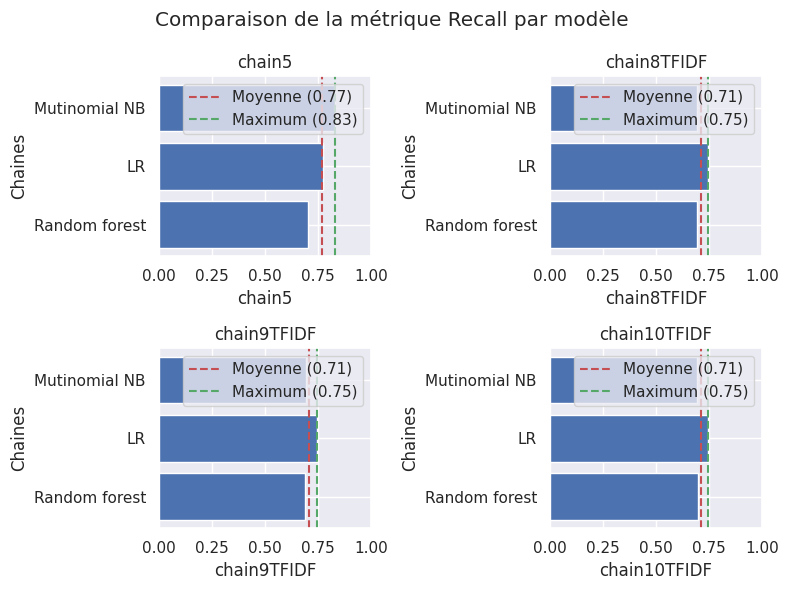

In [40]:
# 3ème chaine bis
comparer_chaines(classification_reports)

On garde bien la chaine 5, avec les sacs de mots plus performants que tf-idf.

### Quatrièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Fréquences** 

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 5 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 11 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.1) + informations statistiques | 
| 12 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.1) + informations statistiques | 
| 13 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.01) + informations statistiques | 

In [42]:
chaines = [
    ('chain5', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain11', ColumnTransformer(
        [
            ('headline_tfidf_010', tfidf_010, 'headline'),
            ('text_bow_010', bow_010, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain12', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_010', bow_010, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain13', ColumnTransformer(
        [
            ('headline_tfidf_010', tfidf_010, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [43]:
# 4ème chaine
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

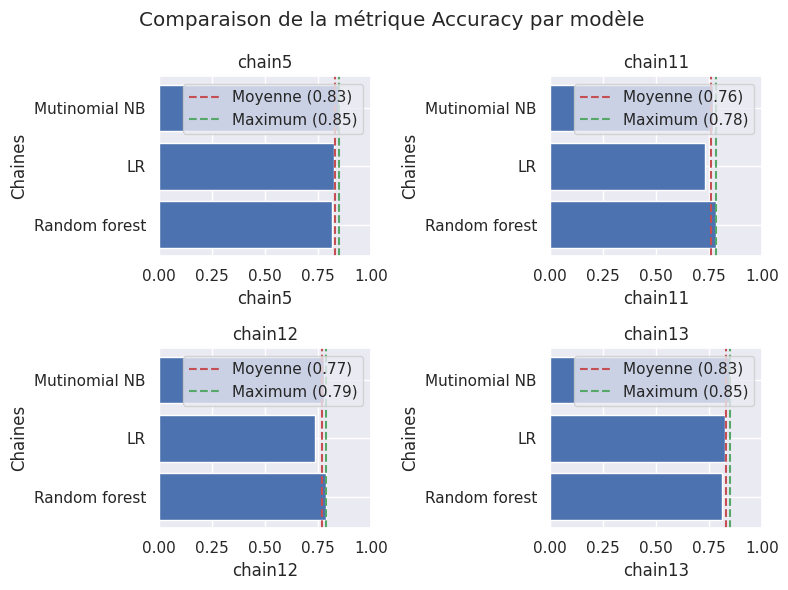

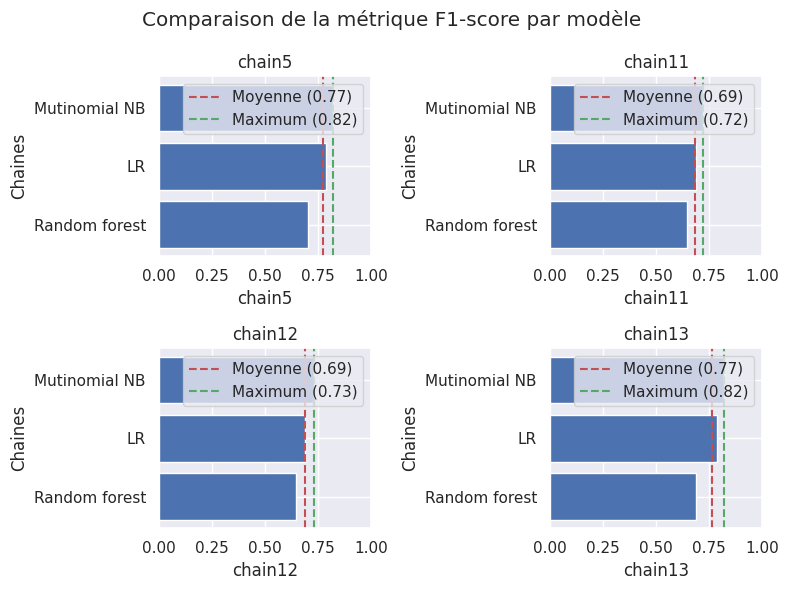

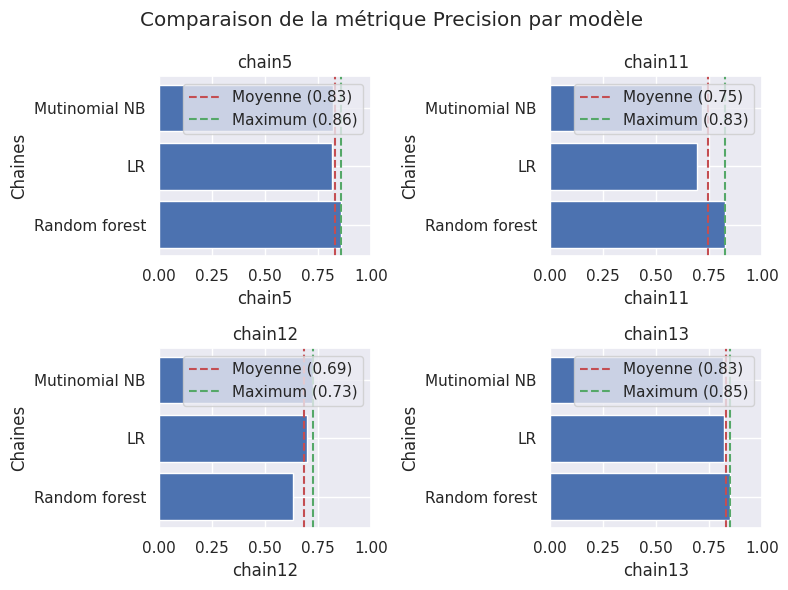

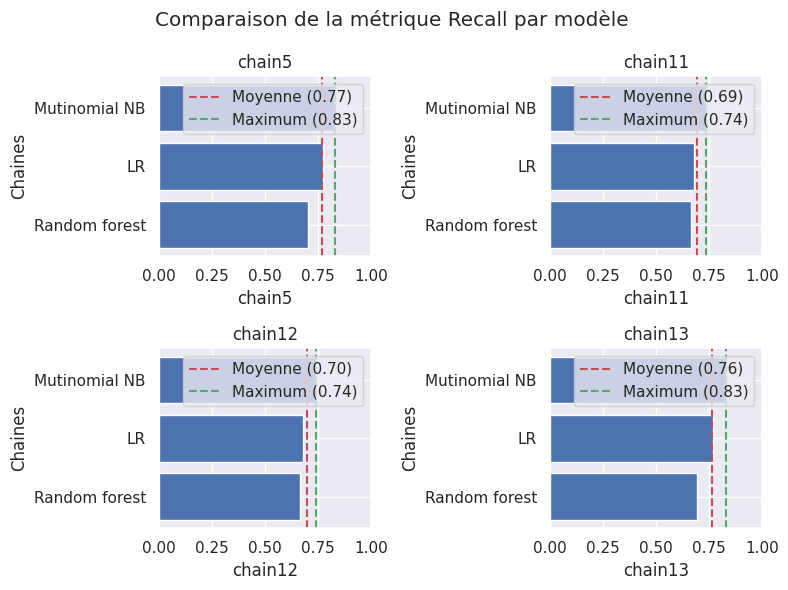

In [44]:
# 4ème chaine
comparer_chaines(classification_reports)

On élimine les chaines 11 et 12, moins performantes (pour toutes les métriques).

### Cinquièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Fréquences** 

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 5 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 13 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.01) + informations statistiques |
| 14 | tf-idf (fréquence = 0.05) | sac de mots (fréquence = 0.05) + informations statistiques | 
| 15 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.05) + informations statistiques |  

In [45]:
chaines = [
    ('chain5', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain13', ColumnTransformer(
        [
            ('headline_tfidf_010', tfidf_010, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain14', ColumnTransformer(
        [
            ('headline_tfidf_005', tfidf_005, 'headline'),
            ('text_bow_005', bow_005, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain15', ColumnTransformer(
        [
            ('headline_tfidf_010', tfidf_010, 'headline'),
            ('text_bow_005', bow_005, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]

In [46]:
# 5ème chaine : fréquences 0.05
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

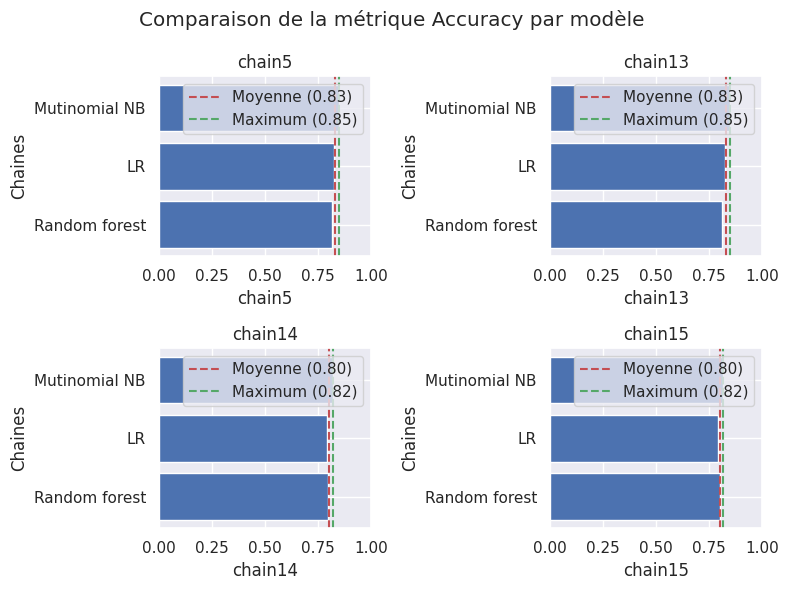

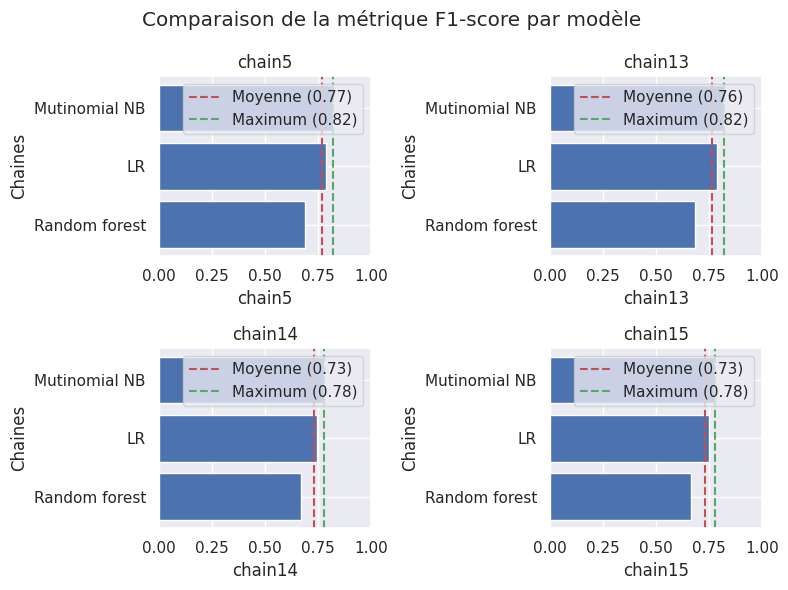

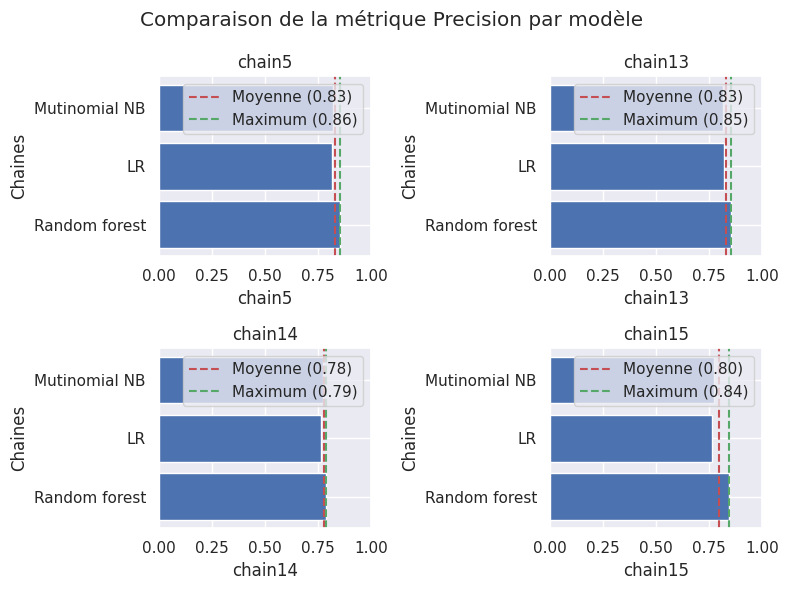

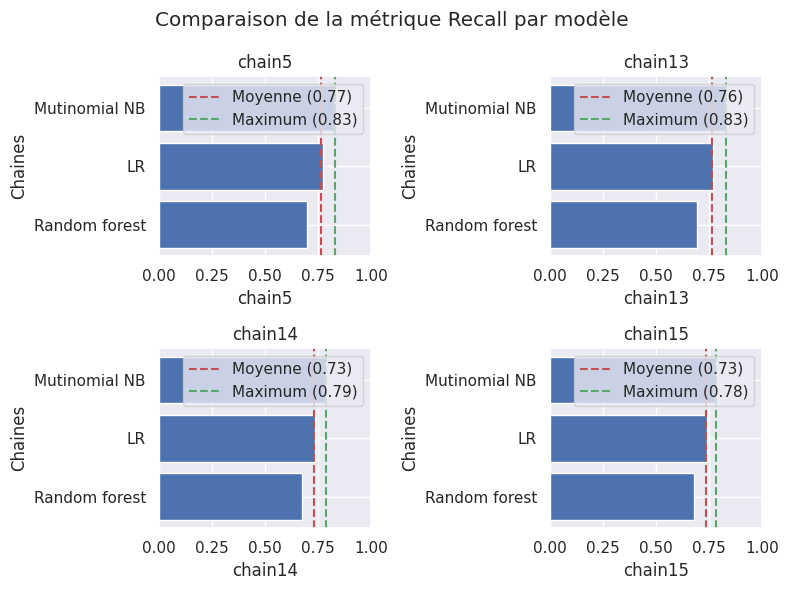

In [47]:
# 5ème chaine : fréquences 0.05
comparer_chaines(classification_reports)

On conserve la chaine 5 qui obtient les mêmes scores pour toutes les mesures que la chaine 13, légèrement meilleure en terme de précision.  
Les chaines 14 et 15 sont moins performantes.

### Sixièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Désuffixation**

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 5 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 16 | tf-idf (fréquence = 0.01) + stemming | sac de mots (fréquence = 0.01) + informations statistiques | 
| 17 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques + stemming | 
| 18 | tf-idf (fréquence = 0.01) + stemming | sac de mots (fréquence = 0.01) + informations statistiques + stemming | 


In [52]:
chaines = [
    ('chain5', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain16', ColumnTransformer(
        [
            ('headline_tfidf_001_stem', 
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('tfidf', tfidf_001),
                 ]
                ),
                 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    ('chain17', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001_stem',  
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('bow', bow_001),
                 ]
                ),
                 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    ('chain18', ColumnTransformer(
        [
            ('headline_tfidf_001_stem', 
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('tfidf', tfidf_001),
                 ]
                ),
                 'headline'),
            ('text_bow_001_stem',  
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('bow', bow_001),
                 ]
                ),
                 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [53]:
# 6 ème chaine : stem
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

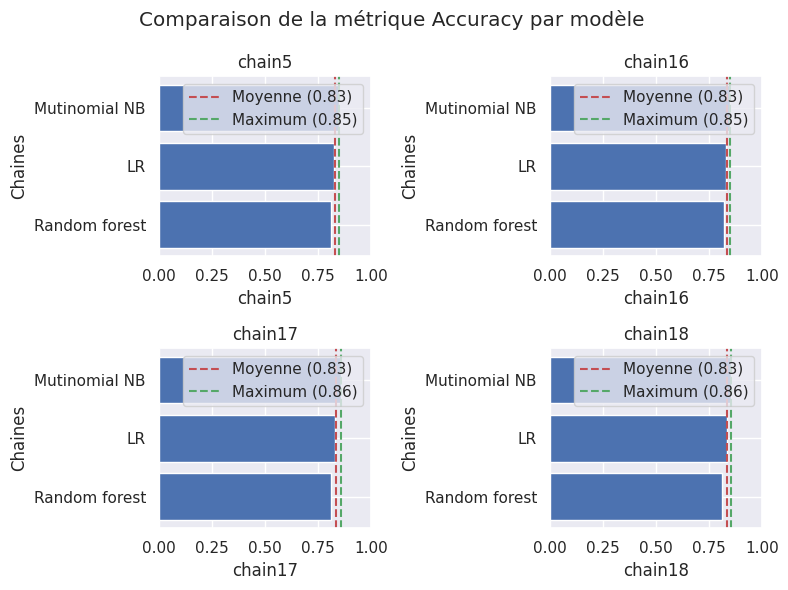

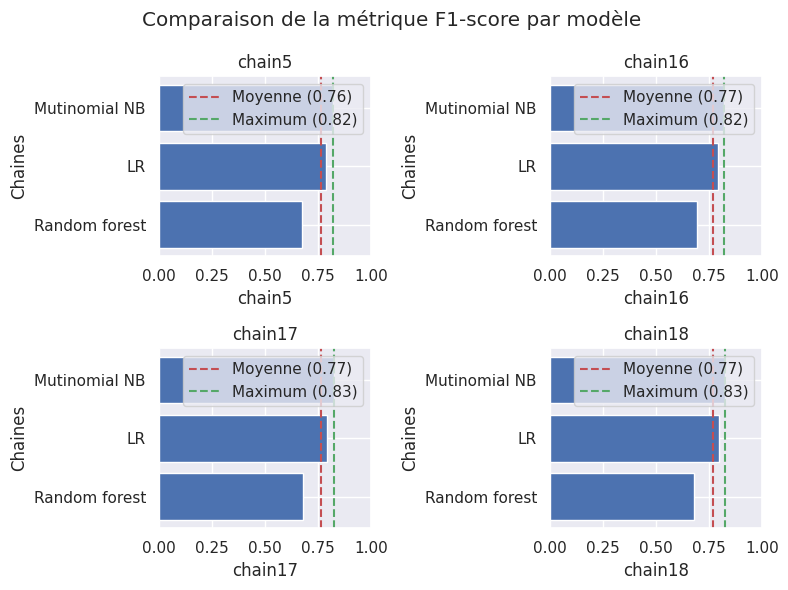

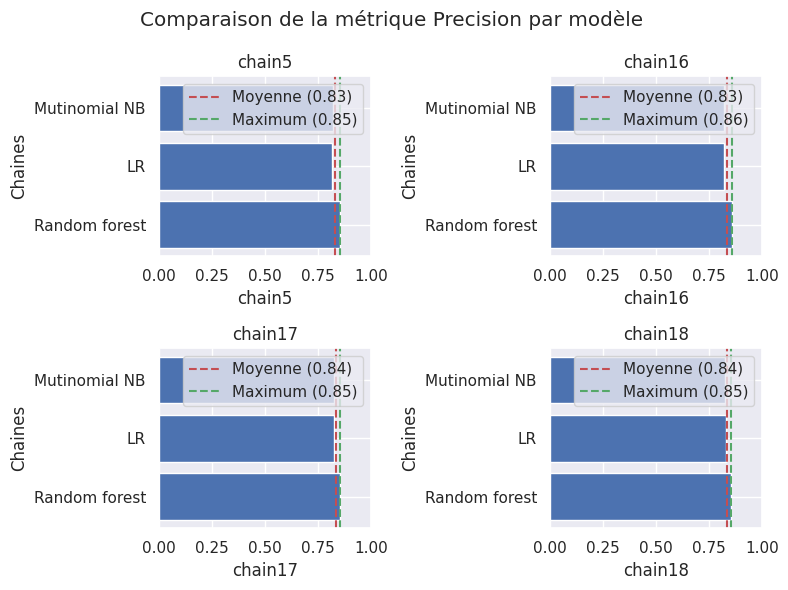

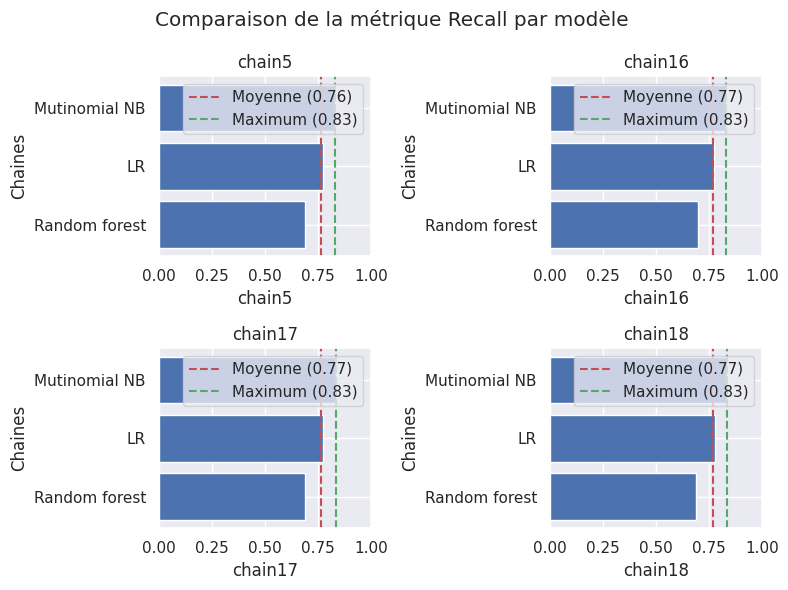

In [54]:
# 6 ème chaine : stem
comparer_chaines(classification_reports)

Les chaines 17 et 18 sont meilleures en terme d'exactitude et de F1-score.  
On garde donc la chaine 17.

### Septièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- Désuffixation
- **Lemmatisation**

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 17 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques + stemming | 
| 19 | tf-idf (fréquence = 0.01) + lemmatisation | sac de mots (fréquence = 0.01) + informations statistiques + stemming | 
| 20 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques + stemming + lemmatisation | 
| 21 | tf-idf (fréquence = 0.01) + lemmatisation | sac de mots (fréquence = 0.01) + informations statistiques + stemming + lemmatisation | 

In [55]:
chaines = [
    ('chain17', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001_stem',  
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('bow', bow_001),
                 ]
                ),
                 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain19', ColumnTransformer(
        [
            ('headline_tfidf_001_lem', 
                Pipeline(
                 [
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('tfidf', tfidf_001),
                 ]
                ),
                 'headline'),
            ('text_bow_001_stem',  
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('text_stats', bow_001),
                 ]
                ),
                 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain20', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001_stem_lemm',  
              Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('bow', bow_001),
                 ]
                ),
              'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain21', ColumnTransformer(
        [
            ('headline_tfidf_001_lem', 
                Pipeline(
                 [
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('tfidf', tfidf_001),
                 ]
                ),
                 'headline'),
            ('text_bow_001_stem_lemm',  
              Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('bow', bow_001),
                 ]
                ),
              'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]

In [56]:
# 7ème chaine lemmatisation
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

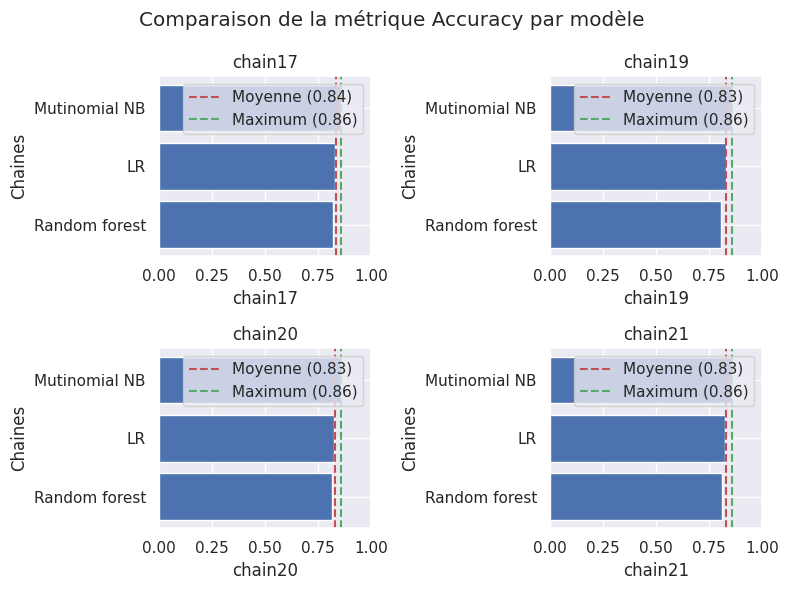

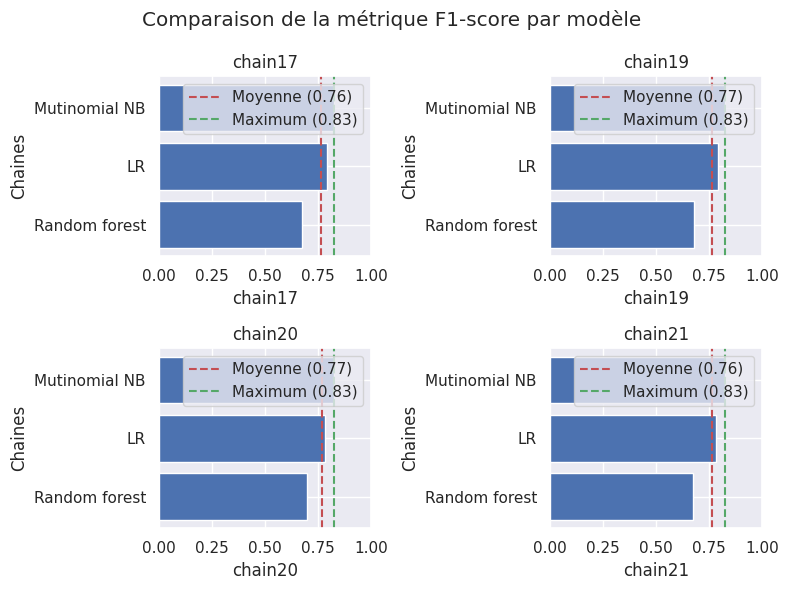

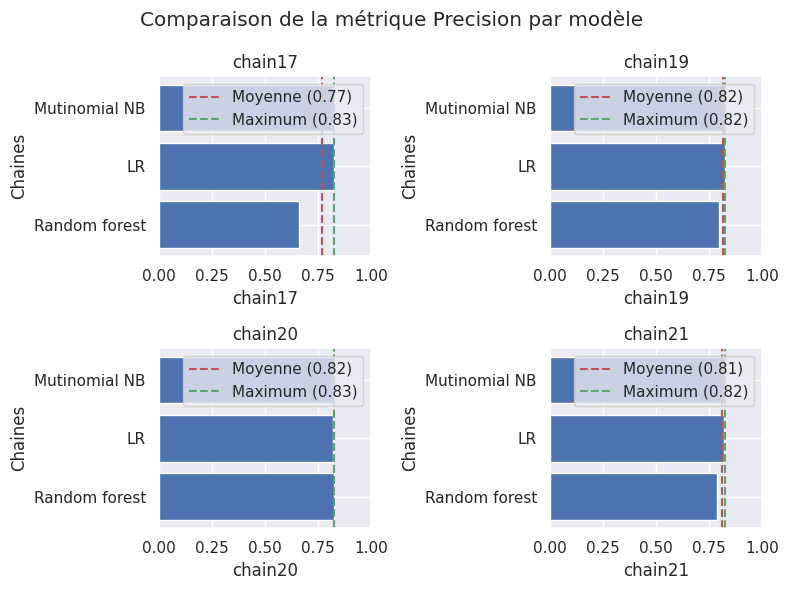

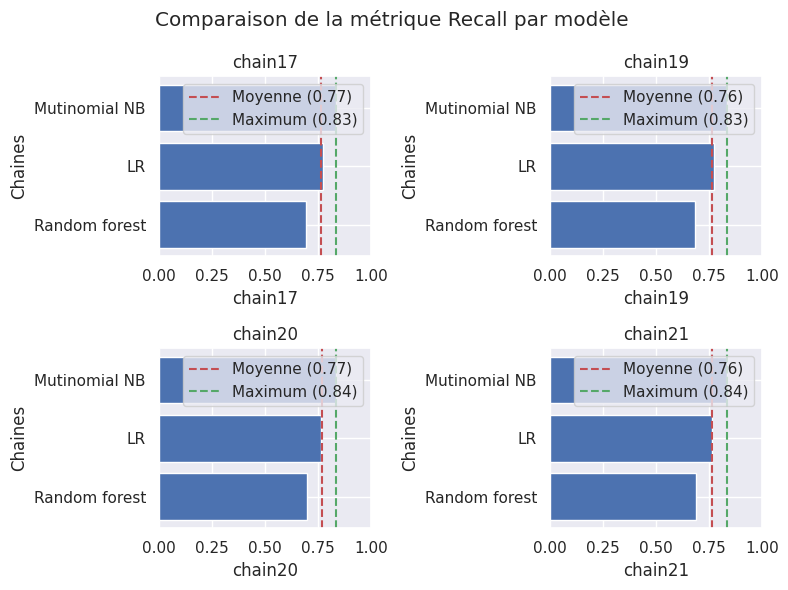

In [57]:
# 7ème chaine lemmatisation
comparer_chaines(classification_reports)

### Choix modèle et trait optimaux

Finalement, on conserve le modèle Multinomial NB car il nous permet de sélectionner l'accuracy et le F1-score maximaux.

Inspection des valeurs pour les 4 chaines :

In [58]:
def round_dict_values(d):
    return {k: round(v, 3) for k, v in d.items()}

print("17",classification_reports["chain17"]["Mutinomial NB"])
print("19",classification_reports["chain19"]["Mutinomial NB"])
print("20",classification_reports["chain20"]["Mutinomial NB"])
print("21",classification_reports["chain21"]["Mutinomial NB"])


17 {'accuracy': 0.8569491525423729, 'f1-score': 0.8278099231540826, 'precision': 0.8244840298529853, 'recall': 0.8339726393347264}
19 {'accuracy': 0.8569491525423729, 'f1-score': 0.8278099231540826, 'precision': 0.8244840298529853, 'recall': 0.8339726393347264}
20 {'accuracy': 0.8583050847457627, 'f1-score': 0.8278586151680496, 'precision': 0.8238989637384575, 'recall': 0.8351171338087339}
21 {'accuracy': 0.8583050847457627, 'f1-score': 0.8278586151680496, 'precision': 0.8238989637384575, 'recall': 0.8351171338087339}


On sélectionne donc finalement la chaine 20 (scores égaux à 21 mais 21 lemmatise en plus le titre, ce que ne fait pas 20) car maximise l'exactitude et le F1-score.

La combinaison sélectionnée est donc 
- modèle = Multinomial NB
- traits = 
  - HEADLINE : TF-IDF, fréquence 0.1 
    - Prétraitement :
      - Nettoyage du texte
      - Tokenisation
      - Suppression des mots vides
  - TEXTE : Sac de mots, fréquence 0.01
    - Prétraitement : 
      - Nettoyage du texte
      - Tokenisation
      - Suppression des mots vides
      - Stemming
      - Lemmatisation
    - Informations statistiques sur le texte
      - Longueur du texte en nombre de caractères, nombre de phrases


accuracy : 0.8583050847457627  
f1-score : 0.8278586151680496  
precision : 0.8238989637384575  
recall : 0.8351171338087339

---
## BiLSTM

In [59]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
sns.set_theme(style="darkgrid")

### Chargement des données

Les dossiers suivant contiennent les vecteurs de mots pré-entrainés utilisés, ils doivent être téléchargés et dézippés :
- https://nlp.stanford.edu/data/glove.6B.zip
- https://nlp.stanford.edu/data/glove.42B.300d.zip

#### Corpus annoté

In [61]:
# LOn recharge les données (différentes parties du notebook fait séparément)
df = pd.read_csv("train.tsv", sep='\t')

In [62]:
# Liste des classes
class_names = sorted(df['category'].unique())
print("Classes :", class_names)
print("Nombre d'exemplaires :", len(df))

Classes : ['business', 'health', 'politics', 'sports', 'technology']
Nombre d'exemplaires : 1476


In [63]:
# On associe à chaque classe un identifiant unique
class_index = {class_names[i]:i for i in range(len(class_names))}
class_index

{'business': 0, 'health': 1, 'politics': 2, 'sports': 3, 'technology': 4}

In [64]:
# Concaténation du titre et du texte pour l'input
X = df["headline"] + ' ' + df["text"]

# Remplacement des noms des classes par un entier
y = df["category"].map(class_index)

In [65]:
def get_vectorizer(documents, max_voc_size=8000, max_seq_length=50, batch_size=128):
  vectorizer = TextVectorization(max_tokens=max_voc_size,
                                 output_sequence_length=max_seq_length)
  text_ds = tf.data.Dataset.from_tensor_slices(documents).batch(batch_size)
  vectorizer.adapt(text_ds)
  return vectorizer

In [66]:
keras_vectorizer = get_vectorizer(X)

2024-05-03 10:05:51.493599: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-03 10:05:51.727996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [67]:
voc = keras_vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

#### Plongements de mots pré-entraînés

On teste 3 plongements pré-entrainés : 
- globe 42B
- glove 6B
- m26


In [68]:
def load_embeddings(embeddings_file):
  embeddings_index = {}
  with open(embeddings_file, 'r', encoding='utf8') as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs
  print(f'{len(embeddings_index)} vecteurs de mots ont été lus')
  return embeddings_index

In [70]:
# Chargement des différents plongements pré entrainés
glove_embeddings_42B = load_embeddings('glove.42B.300d.txt')
glove_embeddings_6B = load_embeddings('glove.6B/glove.6B.300d.txt')

1917494 vecteurs de mots ont été lus
400000 vecteurs de mots ont été lus


In [71]:
!wget -P data https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/model_26.txt

--2024-05-03 10:07:18--  https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/model_26.txt
Résolution de git.unistra.fr (git.unistra.fr)… 130.79.254.48
Connexion à git.unistra.fr (git.unistra.fr)|130.79.254.48|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 17389513 (17M) [text/plain]
Enregistre : ‘data/model_26.txt.1’

model_26.txt.1      100%[===================>]  16,58M  66,2KB/s    ds 19s     

2024-05-03 10:07:38 (881 KB/s) - ‘data/model_26.txt.1’ enregistré [17389513/17389513]



In [72]:
m26_embeddings = load_embeddings('data/model_26.txt')

6082 vecteurs de mots ont été lus


In [73]:
def get_embedding_matrix(vocabulary, embeddings_index, embedding_dim = 300):
  num_tokens = len(vocabulary)
  hits = 0
  misses = 0

  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print(f'{hits} mots ont été trouvés dans les plongements pré-entraînés')
  print(f'{misses} sont absents')
  return embedding_matrix

### Construction des différentes matrices de plongements à partir des 3 plongements pré-entrainés

In [74]:
glove_embedding_42B_matrix = get_embedding_matrix(voc, glove_embeddings_42B)

glove_embedding_6B_matrix = get_embedding_matrix(voc, glove_embeddings_6B)

m26_matrix = get_embedding_matrix(voc, m26_embeddings)

6147 mots ont été trouvés dans les plongements pré-entraînés
1853 sont absents
3619 mots ont été trouvés dans les plongements pré-entraînés
4381 sont absents
625 mots ont été trouvés dans les plongements pré-entraînés
7375 sont absents


### Construction et entraînement du modèle

In [75]:
def get_biLSTM_model(voc_size, embedding_matrix, embedding_dim=300):
  int_sequences_input = keras.Input(shape=(None,), dtype="int64")
  embedding_layer = Embedding(voc_size, embedding_dim, trainable=True,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix),
  )

  embedded_sequences = embedding_layer(int_sequences_input)
  x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedded_sequences)
  preds = layers.Dense(len(class_names), activation="softmax")(x)
  model = keras.Model(int_sequences_input, preds)
  return model

#### Affichage de l'architecture pour les 3 modèles

In [76]:
biLSTM_model_42B = get_biLSTM_model(len(voc), glove_embedding_42B_matrix)
biLSTM_model_42B.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 300)      │     2,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,525 (9.87 MB)

 Trainable params: 2,587,525 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
biLSTM_model_6B = get_biLSTM_model(len(voc), glove_embedding_6B_matrix)
biLSTM_model_6B.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 300)      │     2,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,525 (9.87 MB)

 Trainable params: 2,587,525 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
biLSTM_model_m26 = get_biLSTM_model(len(voc), m26_matrix)
biLSTM_model_m26.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 300)      │     2,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,525 (9.87 MB)

 Trainable params: 2,587,525 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Fonction pour l'entraînement d'un modèle
def train_model(X, y, model_function, vectorizer,
                voc_size, embedding_matrix, embedding_dim=300, batch_size=128):
  acc_per_fold = []
  loss_per_fold = []
  histories = []
  folds = 5
  stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True,
                                              random_state=3)
  fold_no = 1
  for train, test in stratkfold.split(X, y):
    m_function = globals()[model_function]
    model = m_function(voc_size, embedding_matrix, embedding_dim)

    print('------------------------------------------------------------------------')
    print(f'Entraînement pour le pli {fold_no} ...')
    fold_x_train = vectorizer(X.iloc[train].to_numpy()).numpy()
    fold_x_val = vectorizer(X.iloc[test].to_numpy()).numpy()
    fold_y_train = y.iloc[train].to_numpy()
    fold_y_val = y.iloc[test].to_numpy()
    
    model.compile(
      loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
    )
    # Entraînement
    history = model.fit(fold_x_train, fold_y_train, batch_size=batch_size,
                        epochs=10, validation_data=(fold_x_val, fold_y_val))
    histories.append(history)
    # Evaluation sur les données de validation
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    print(f'Scores pour le pli {fold_no}: {model.metrics_names[0]} = {scores[0]:.2f};',
          f'{model.metrics_names[1]} = {scores[1]*100:.2f}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no = fold_no + 1

  # Affichage des scores moyens par pli
  print('---------------------------------------------------------------------')
  print('Scores par pli')
  for i in range(0, len(acc_per_fold)):
    print('---------------------------------------------------------------------')
    print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}',
          f'- Accuracy: {acc_per_fold[i]:.2f}%')
  print('---------------------------------------------------------------------')
  print('Scores moyens pour tous les plis :')
  print(f'> Accuracy: {np.mean(acc_per_fold):.2f}',
        f'(+- {np.std(acc_per_fold):.2f})')
  print(f'> Loss: {np.mean(loss_per_fold):.2f}')
  print('---------------------------------------------------------------------')
  return histories

#### Entrainement du modèle

In [80]:
biLSTM_histories_42B = train_model(X, y, 'get_biLSTM_model',
                            keras_vectorizer, len(voc), glove_embedding_42B_matrix)

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.2747 - loss: 1.5335 - val_acc: 0.4628 - val_loss: 1.3704
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.5006 - loss: 1.3340 - val_acc: 0.5507 - val_loss: 1.2196
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.5565 - loss: 1.1651 - val_acc: 0.5608 - val_loss: 1.1182
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.6219 - loss: 1.0874 - val_acc: 0.5811 - val_loss: 1.0512
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.6510 - loss: 0.9705 - val_acc: 0.6014 - val_loss: 0.9682
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.6798 - loss: 0.9056 - val_acc: 0.7162 - val_loss: 0.8380
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.7068 - loss: 0.8450 - val_acc: 0.6622 - val_loss: 0.8607
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.7503 - loss: 0.76

In [81]:
biLSTM_histories_6B = train_model(X, y, 'get_biLSTM_model',
                            keras_vectorizer, len(voc), glove_embedding_6B_matrix)

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.3333 - loss: 1.4930 - val_acc: 0.5473 - val_loss: 1.2958
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.5458 - loss: 1.2552 - val_acc: 0.5743 - val_loss: 1.1687
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.5916 - loss: 1.1272 - val_acc: 0.6250 - val_loss: 1.0551
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.6290 - loss: 1.0175 - val_acc: 0.6115 - val_loss: 0.9707
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.6229 - loss: 0.9939 - val_acc: 0.6081 - val_loss: 0.9783
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6935 - loss: 0.9016 - val_acc: 0.6047 - val_loss: 0.9938
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6854 - loss: 0.8351 - val_acc: 0.6791 - val_loss: 0.8388
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.7352 - loss: 0.77

In [82]:
biLSTM_histories_m26 = train_model(X, y, 'get_biLSTM_model',
                            keras_vectorizer, len(voc), m26_matrix)

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.2795 - loss: 1.5682 - val_acc: 0.3074 - val_loss: 1.5079
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.3586 - loss: 1.5043 - val_acc: 0.3682 - val_loss: 1.4728
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.4604 - loss: 1.4491 - val_acc: 0.4797 - val_loss: 1.4225
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.5106 - loss: 1.3735 - val_acc: 0.3750 - val_loss: 1.3953
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.4983 - loss: 1.3117 - val_acc: 0.5507 - val_loss: 1.2446
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.6129 - loss: 1.1546 - val_acc: 0.6318 - val_loss: 1.1268
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6323 - loss: 1.0563 - val_acc: 0.6655 - val_loss: 1.0341
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7009 - loss: 0.91

#### Afficher résultats

In [83]:
def plot_results(histories):
  accuracy_data = []
  loss_data = []
  for i, h in enumerate(histories):
    acc = h.history['acc']
    val_acc = h.history['val_acc']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    for j in range(len(acc)):
      accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
      accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
      loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
      loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

  acc_df = pd.DataFrame(accuracy_data,
                        columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
  sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données',
              kind='line')

  loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
  sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données',
              kind='line')

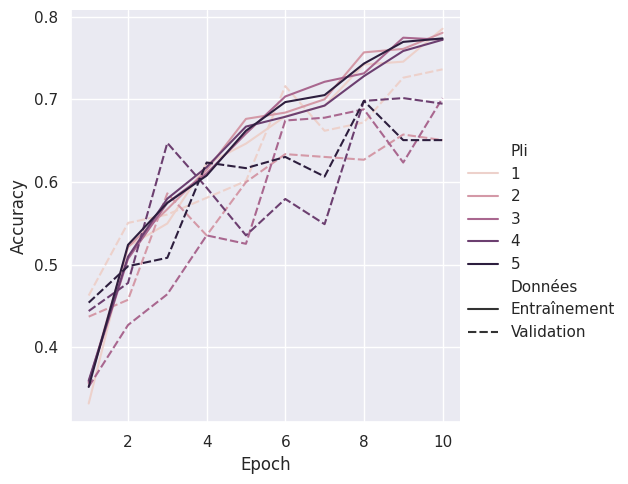

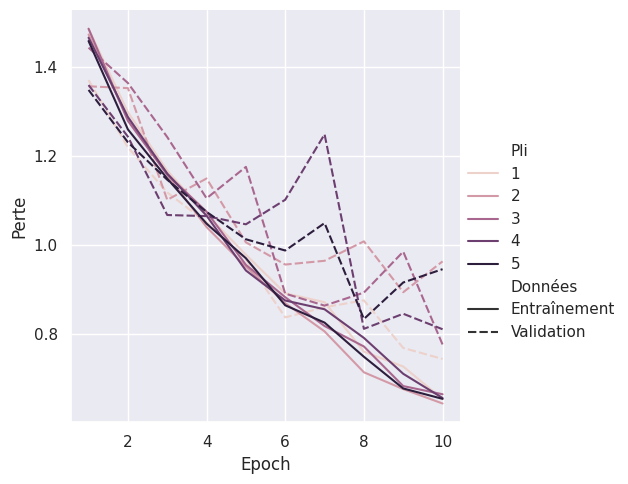

In [84]:
plot_results(biLSTM_histories_42B)

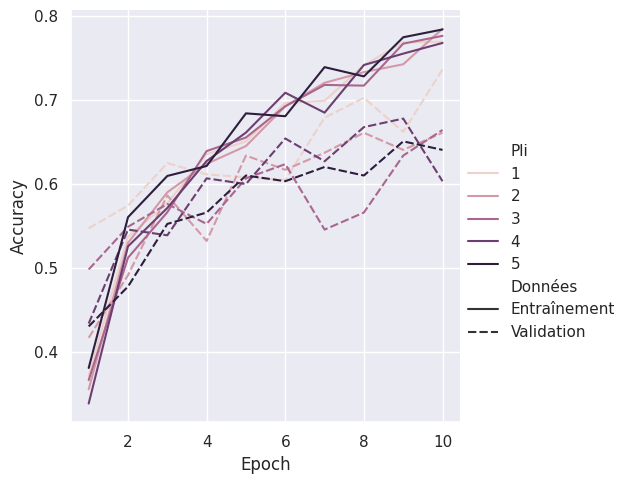

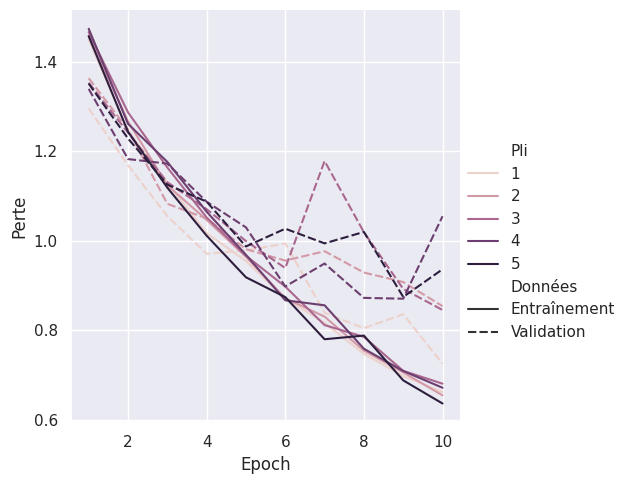

In [85]:
plot_results(biLSTM_histories_6B)

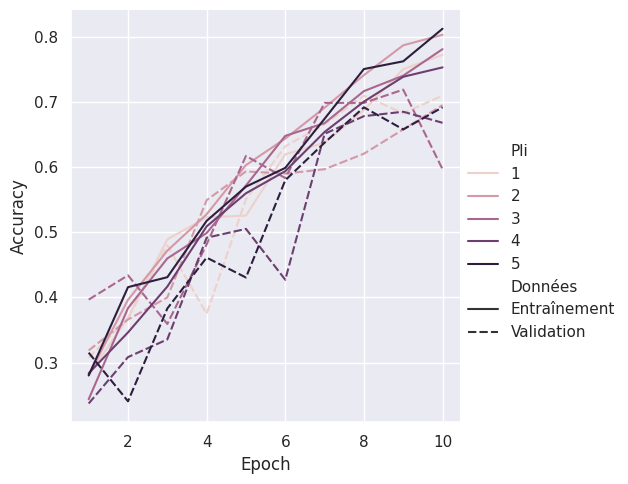

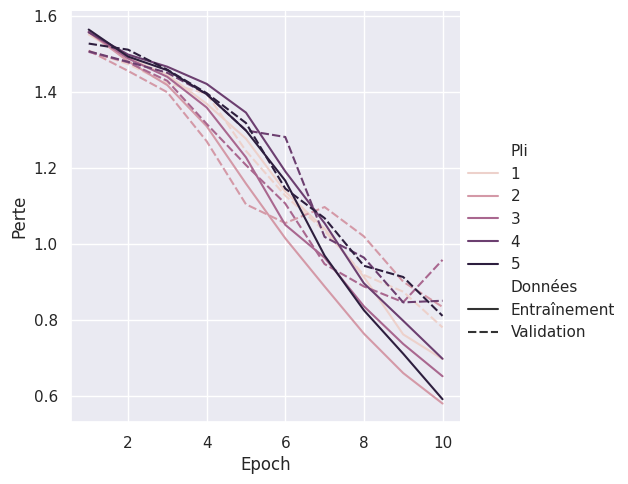

In [86]:
plot_results(biLSTM_histories_m26)

## Analyse des résultats BI-LSTM

Dans les modèles entrainés précédents on observe :
- pour glove 42B
    > Scores moyens pour tous les plis :  
    > Accuracy: 68.70 (+- 3.27)
- pour globe 6B
    > Scores moyens pour tous les plis :  
    > Accuracy: 66.12 (+- 4.35)
- pour m26
    > Scores moyens pour tous les plis :  
    > Accuracy: 67.21 (+- 4.00)

Ces 3 modèles sont donc très clairement moins bons (juste pour l'exactitude) que la combinaison 20 retenue précédemment.

---
## Transformers

### Installation

In [1]:
! pip install transformers[torch]

Defaulting to user installation because normal site-packages is not writeable


In [2]:
! pip install datasets torch torchvision torchaudio evaluate sentencepiece sacremoses

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Features, Value, ClassLabel, Dataset, DatasetDict
import evaluate
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch

2024-05-03 14:19:56.612573: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 14:19:56.638927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 14:19:57.085963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/zoe/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Préparation

In [4]:
df = pd.read_csv("train.tsv", sep='\t', dtype={'headline': 'object', 
                                               'text':'object',
                                               'category': 'category' })

In [5]:
# Liste des classes
class_names = sorted(df.category.unique().categories.to_list())
print(class_names)

# On associe à chaque classe un identifiant unique
label2id = {class_names[i]:i for i in range(len(class_names))}
id2label = {i:class_names[i] for i in range(len(class_names))}
print(label2id)
print(id2label)

['business', 'health', 'politics', 'sports', 'technology']
{'business': 0, 'health': 1, 'politics': 2, 'sports': 3, 'technology': 4}
{0: 'business', 1: 'health', 2: 'politics', 3: 'sports', 4: 'technology'}


In [6]:
data_df = pd.DataFrame()
data_df['text'] = df.headline + ' ' + df.text
data_df['label'] = df.category.map(label2id)

In [7]:
data_df.dtypes

text       object
label    category
dtype: object

In [8]:
# Transformation du DataFrame en objet de type Dataset utilisé par HuggingFace
category_features = Features({'text': Value('string'),
                              'label': ClassLabel(names=class_names)})

data = Dataset.from_pandas(data_df, features=category_features)
# Découpage en train et test
data = data.train_test_split(test_size=0.2, shuffle=True, seed=3)


### Tokénisation des données

On utilise flaubert/flaubert_large_cased

In [9]:
model_ckpt = "flaubert/flaubert_large_cased"
# Chargement du tokéniseur pré-entraîné correspondant au modèle utilisé
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [10]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

In [11]:
# Tokenisation de la totalité des données : chaque unité est remplacée par un identifiant numérique
tokenized_data = data.map(preprocess_function, batched=True, batch_size=None)

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

In [12]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_data['train'][0]['input_ids'])
print(tokenized_data['train'][0]['text'])
print(tokens)

Guerre Ukraine - Russie : la condamnation à mort d'un Marocain est ignorée - sa sœur La sœur du Marocain qui a été condamné à mort par un tribunal mandataire russe dans l'est de l'Ukraine dit qu'elle a le sentiment que son histoire est ignorée - et qu'il pourrait être oublié. Brahim Saadoune a été condamné aux côtés des Britanniques Aiden Aslin et Shaun Pinner, qui ont été beaucoup plus médiatisés. Lire aussi sur BBC Afrique : M. Saadoune, 21 ans, étudiait en Ukraine mais s'est engagé à combattre à la défense de Marioupol. Lorsqu'il s'est rendu - il a été jugé, avec les deux autres, non pas en tant que soldat mais en tant que mercenaire. "Au début, quand ils les capturaient tous les deux, c'était comme si les informations étaient différentes pour chaque personne", explique Imane Saadoune. ''Il n'y avait pas beaucoup d'attention sur mon frère… il a été un peu laissé de côté. C'est peut-être à cause de mon gouvernement qui ne fait pas grand-chose à ce sujet, ils sont littéralement silenc

In [13]:
# Taille du vocabulaire
tokenizer.vocab_size

68729

In [14]:
# Taille de contexte maximum
tokenizer.model_max_length

512

### Préparation de l'évaluation

In [15]:
accuracy = evaluate.load("accuracy")

In [16]:
f1_metric = evaluate.load("f1")

In [17]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    return {"accuracy": acc['accuracy'], "f1-macro": f1["f1"]}

### Entrainement par affinage

In [18]:
import torch
print(torch.cuda.is_available())

# Vérifier la disponibilité de CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA est disponible!")
else:
    device = torch.device("cpu")
    print("CUDA n'est pas disponible, utilisation du CPU.")

# Utiliser le périphérique pour le traitement
tensor = torch.tensor([1, 2, 3]).to(device)
print("Tensor :", tensor)


False
CUDA n'est pas disponible, utilisation du CPU.
Tensor : tensor([1, 2, 3])


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
batch_size = 64
training_args = TrainingArguments(
    output_dir=f"{model_ckpt}-classification",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    #logging_dir="./logs",
)

In [21]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def init_trainer():
  model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=len(class_names), id2label=id2label, label2id=label2id
    ).to(device)
  trainer =  Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_data["train"],
      eval_dataset=tokenized_data["test"],
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
  )
  return trainer, model

In [22]:
trainer, model = init_trainer()

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_large_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:

# trainer.train()

# OUTPUT = 
# The Kernel crashed while executing code in the current cell or a previous cell. 
# Please review the code in the cell(s) to identify a possible cause of the failure. 
# Click here for more info. 
# View Jupyter log for further details.


  0%|          | 0/95 [00:00<?, ?it/s]

: 

## Conclusion sur Transformers

Le problème rencontré est lié à la nécessité d'avoir un GPU pour exécuter les opérations requises. Les ordinateurs utilisés ne disposent pas de suffisamment de puissance pour répondre aux exigences de traitement, ce qui entraîne des erreurs lors de l'exécution du code. Même en utilisant une solution distante comme Guacamole sur les ordinateurs de la faculté, le problème persiste. Il est clair que l'utilisation d'un GPU est indispensable pour réaliser les tâches envisagées. Ces difficultés ont également été rencontrées lors du TP3, confirmant ainsi le besoin d'une solution adaptée pour l'exécution des modèles. On note d'ailleurs que dans le TP3, la validation croisée n'avait pas été utilisée.

Dans la section suivante, nous examinerons de près les modèles que nous avons pu obtenir jusqu'à présent et tirerons des conclusions pertinentes sur leur performance. 

Bien que nous ayons préparé les données et le code nécessaire pour l'entraînement des modèles, nous avons été limités par les capacités matérielles de nos ordinateurs. Pour illustrer notre progression, nous avons laissé le code correspondant dans le notebook, en veillant à ne pas exécuter (en commentant) la cellule précédente pour éviter de surcharger le Kernel.

---
## Modèle final

In [180]:
modeleFinal = MultinomialNB()

In [181]:
chainFinal = ColumnTransformer(
        [
            
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001_stem_lemm',  
              Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('bow', bow_001),
                 ]
                ),
              'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
            )
        ]
    )

### 

---
## Application du meilleur modèle aux données de test

In [182]:
#Chargement du jeu de données de test
df_test = pd.read_csv("test.tsv", sep='\t')
df_train = pd.read_csv("train.tsv", sep='\t')

Les jeux ont été modifiés plusieurs fois depuis le début du notebook : on recharge les premières étapes pour être certaines de ne pas avoir modifier X et y et retrouver ce qu'on a réalisé avant Bi-LSTM et Transformers.

In [183]:
# traitement initial
df_train = df_train.drop_duplicates()
X_train = df_train[['headline', 'text']]
y_train = df_train.category

In [184]:
model_pipeline_Final = make_pipeline(chainFinal, modeleFinal)
model_pipeline_Final.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('headline_tfidf_001',
                                                  TfidfVectorizer(min_df=0.01,
                                                                  token_pattern=None,
                                                                  tokenizer=<function split_into_tokens_nltk at 0x71c07c11fb50>),
                                                  'headline'),
                                                 ('text_bow_001_stem_lemm',
                                                  Pipeline(steps=[('stemming',
                                                                   FunctionTransformer(func=<function stemming_transformer at 0x71c07c172950>)),
                                                                  ('lemmatizat...
                                                                   FunctionTransformer(func=<function lemmatization_transformer at 0x71c07c171480>)),
                                                                  ('bow',
                                                                   CountVectorizer(min_df=0.01,
                                                                                   token_pattern=None,
                                                                                   tokenizer=<function split_into_tokens_nltk at 0x71c07c11fb50>))]),
                                                  'text'),
                                                 ('text_stats',
                                                  Pipeline(steps=[('text_stats',
                                                                   FunctionTransformer(func=<function text_stats at 0x71c07c172a70>)),
                                                                  ('vect',
                                                                   DictVectorizer(sparse=False)),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  'text')])),
                ('multinomialnb', MultinomialNB())])

In [185]:
X_test = df_test[['headline', 'text']]
y_test = df_test.category

In [186]:
y_pred = model_pipeline_Final.predict(X_test)
print("Classification report:\n\n{}".format(classification_report(y_test, y_pred)))

Classification report:

              precision    recall  f1-score   support

    business       0.80      0.74      0.77       100
      health       0.94      0.90      0.92       100
    politics       0.81      0.91      0.85       100
      sports       0.97      0.94      0.95       100
  technology       0.58      0.64      0.61        22

    accuracy                           0.86       422
   macro avg       0.82      0.83      0.82       422
weighted avg       0.86      0.86      0.86       422



Pour rappel : avec validation croisée sur jeu `train.tsv` on avait obtenu :   
accuracy : 0.8583050847457627  
f1-score : 0.8278586151680496  
precision : 0.8238989637384575  
recall : 0.8351171338087339

On retrouve donc les mêmes valeurs !

---
## Analyse : Explication des prédictions

On réalise l'explication des prédictions sur le jeu `test.tsv`

In [187]:
from lime.lime_text import LimeTextExplainer
class_labels = model_pipeline_Final.classes_
explainer = LimeTextExplainer(class_names=class_labels)
class_labels

array(['business', 'health', 'politics', 'sports', 'technology'],
      dtype='<U10')

In [188]:
idx = 391
print(f'Document id : {idx}')
print(f'Classe prédite : {model_pipeline_Final.predict(X_test.loc[[idx]])}')
print(f'Classe réelle : {y_test.loc[idx]}')

Document id : 391
Classe prédite : ['sports']
Classe réelle : sports


In [189]:
# Obtenir les étapes du pipeline
pipeline_steps = model_pipeline_Final.steps

# Parcourir les étapes et afficher les transformations
for step_name, transformer in pipeline_steps:
    print("Step:", step_name)
    print("Transformer:", transformer)
    print("")

Step: columntransformer
Transformer: ColumnTransformer(transformers=[('headline_tfidf_001',
                                 TfidfVectorizer(min_df=0.01,
                                                 token_pattern=None,
                                                 tokenizer=<function split_into_tokens_nltk at 0x71c07c11fb50>),
                                 'headline'),
                                ('text_bow_001_stem_lemm',
                                 Pipeline(steps=[('stemming',
                                                  FunctionTransformer(func=<function stemming_transformer at 0x71c07c172950>)),
                                                 ('lemmatization',
                                                  FunctionTransformer(func=<functi...atization_transformer at 0x71c07c171480>)),
                                                 ('bow',
                                                  CountVectorizer(min_df=0.01,
                                     

In [199]:
X_idx = X_train.iloc[idx]
X_idx

headline    Adama Traoré : des manifestants antiracistes d...
text        Des milliers de personnes se sont jointes aux ...
Name: 391, dtype: object

In [201]:
type(X_idx)

pandas.core.series.Series

In [203]:
text_example = X_idx[['headline', 'text']].tolist()
text_example

["Adama Traoré : des manifestants antiracistes défient l'interdiction de la police",
 'Des milliers de personnes se sont jointes aux protestations en France à la suite du décès d\'un Noir en garde à vue en 2016, défiant l\'interdiction de manifestation de la police en raison des restrictions liées au coronavirus. Jets de projectiles, tirs de gaz lacrymogènes, manifestants sur le périphérique, barricades... Des heurts ont émaillé ce rassemblement. A lire aussi sur BBC Afrique: La mort d\'Adama Traoré, 24 ans, a été assimilée à celle de George Floyd aux États-Unis, dont le décès a suscité des protestations dans tout le pays. La police a affronté les manifestants dans la banlieue parisienne mardi A Paris, le rassemblement, qui avait débuté en fin d\'après-midi sur le parvis du tribunal dans le nord-est de Paris, a été perturbé par des jets de projectiles et la police a fait usage de gaz lacrymogène. Après la dispersion des manifestants, des affrontements sporadiques ont éclaté sur le boul

In [210]:
text_example = X_idx[['headline', 'text']].values
text_example

array(["Adama Traoré : des manifestants antiracistes défient l'interdiction de la police",
       'Des milliers de personnes se sont jointes aux protestations en France à la suite du décès d\'un Noir en garde à vue en 2016, défiant l\'interdiction de manifestation de la police en raison des restrictions liées au coronavirus. Jets de projectiles, tirs de gaz lacrymogènes, manifestants sur le périphérique, barricades... Des heurts ont émaillé ce rassemblement. A lire aussi sur BBC Afrique: La mort d\'Adama Traoré, 24 ans, a été assimilée à celle de George Floyd aux États-Unis, dont le décès a suscité des protestations dans tout le pays. La police a affronté les manifestants dans la banlieue parisienne mardi A Paris, le rassemblement, qui avait débuté en fin d\'après-midi sur le parvis du tribunal dans le nord-est de Paris, a été perturbé par des jets de projectiles et la police a fait usage de gaz lacrymogène. Après la dispersion des manifestants, des affrontements sporadiques ont éclaté

#### Erreur
Nous faisons face à un défi dans l'adaptation des données d'entrée et du modèle pour permettre à l'explainer Lime de prendre en charge plusieurs colonnes de texte simultanément. Contrairement à notre précédent TP où nous avions un seul texte en entrée, notre modèle actuel nécessite plusieurs chaînes de texte pour effectuer des prédictions. Nous avons tenté de transformer les données ou le modèle pour résoudre ce problème, mais jusqu'à présent, nous n'avons pas réussi à trouver une solution efficace. Il semble que le problème réside dans la représentation des données, car Lime semble avoir des difficultés à traiter plusieurs colonnes de texte simultanément. Nous cherchons donc des moyens de surmonter cette limitation afin de pouvoir utiliser l'explainer Lime de manière efficace avec notre modèle actuel.

In [211]:
exp = explainer.explain_instance(text_example,
                                 classifier_fn=model_pipeline_Final.predict_proba, 
                                 num_features=10,
                                 top_labels=len(class_labels))


TypeError: cannot use a string pattern on a bytes-like object

In [206]:
print('Explications (tokens qui affectent la classification posititivement et négativement)\n')
for i in range(len(class_labels)):
    print(f'Classe {class_labels[i]}')
    print('\n'.join(map(str, exp.as_list(label=i))))
    print()

Explications (tokens qui affectent la classification posititivement et négativement)

Classe business


NameError: name 'exp' is not defined

In [207]:
exp.show_in_notebook(text=False)

NameError: name 'exp' is not defined